In [1]:
%load_ext autoreload
%autoreload 2

import math
import copy
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
import uproot
import pandas as pd
import dask

import vector
import particle
import hepunits

import zuko
import torch
from torch import nn, optim
import lightning as L
from lightning.pytorch import loggers as pl_loggers

from torch.utils.data import DataLoader

from memflow.dataset.data import RootData,ParquetData
from memflow.dataset.dataset import CombinedDataset
from memflow.dataset.tth import ttHRecoDataset,ttHGenDataset
from memflow.read_data import utils
from memflow.callbacks.transfer_flow_callbacks import SamplingCallback


vector.register_awkward()

print (f"Running on GPU : {torch.cuda.is_available()}")
accelerator = 'gpu' if torch.cuda.is_available() else 'cpu'
print (f"Accelerator : {accelerator}")
torch.set_float32_matmul_precision('medium')  
if accelerator =='gpu':
    torch.cuda.empty_cache()
    print (torch.cuda.memory_summary(device=None, abbreviated=True))

Running on GPU : True
Accelerator : gpu
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Requested memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|-----------------------

In [4]:
data = ParquetData(
    files = [
        'all_jets_fullRun2_ttHbb_forTraining_allyears_spanetprov_part1_validation.parquet',
        #'all_jets_fullRun2_ttHTobb_forTraining_2016_PreVFP_v3.parquet',
    ],
    lazy = True,
    # N = 1000,
)
# mask_5j = ak.count(data['jets'].pt,axis=1) >= 5
# data.cut(mask_5j)

# mask_10j = ak.count(data['jets'].pt,axis=1) <= 10
# data.cut(mask_10j)
print (data)

Data object
Loaded branches:
   ... file: 179213
   ... sample: 179213
   ... tree: 179213
Branch in files not loaded:
   ... generator_info
   ... higgs
   ... jets
   ... lepton_partons
   ... lepton_reco
   ... met
   ... partons
   ... partons_matched
   ... prob_ak
   ... weight


In [16]:
data['jets'][0].prov_Thad,data['jets'][0].prov_Tlep,data['jets'][0].prov_H

(<Array [0.596, 0.596, 0.596, 0] type='4 * float64'>,
 <Array [0, 0.46, 0, 0] type='4 * float64'>,
 <Array [0.381, 0.381, 0, 0] type='4 * float64'>)

In [13]:
data['prob_ak'][0].show()

[[0.596, 0, 0.381],
 [0.596, 0.46, 0.381],
 [0.596, 0, 0],
 [0, 0, 0]]


In [3]:
for i in range(10):
    print ('event',i)
    for field in ['pt','btag','matched','prov']:
        print ('\t',field,getattr(data['jets'][i],field))

event 0
	 pt [178, 134, 60.4, 49.6, 34.3]
	 btag [0.991, 0.9, 0.00272, 0.933, 0.00425]
	 matched [True, True, True, True, True]
	 prov [2, 3, 5, 1, 5]
event 1
	 pt [283, 179, 93.4, 69.7, 68.2]
	 btag [0.00724, 0.999, 0.802, 0.00397, 0.548]
	 matched [True, True, True, True, True]
	 prov [4, 1, 3, 5, 2]
event 2
	 pt [394, 149, 105, 91, 79.2, 79.1, 50.2]
	 btag [0.0127, 0.374, 1, 0.00476, 0.093, 0.323, 0.0151]
	 matched [True, True, True, True, True, True, True]
	 prov [4, 3, 1, 5, 5, 2, 1]
event 3
	 pt [118, 104, 91.2, 76.8, 53.5, 48.5, 32.7]
	 btag [0.942, 0.00703, 0.00507, 0.954, 1, 0.0285, 0.0266]
	 matched [True, True, True, True, True, True, True]
	 prov [1, 4, 5, 2, 1, 5, 3]
event 4
	 pt [142, 142, 96.8, 55.1, 54.8, 34.2]
	 btag [0.00543, 0.771, 0.818, 0.858, 0.792, 0.0119]
	 matched [True, True, True, False, True, False]
	 prov [5, 4, 3, -1, 1, -1]
event 5
	 pt [246, 125, 112, 63.2, 52.8, 42.2, 32.8]
	 btag [0.0681, 0.428, 0.273, 0.655, 0.00806, 0.706, 0.997]
	 matched [True, Tru

In [4]:
gen_dataset = ttHGenDataset(
    data = data,
    selection = [
        'higgs',
        'top_leptonic',
        'top_hadronic',
        'ISR',
    ],
    build = True,
    coordinates = 'cylindrical',
    apply_preprocessing = True,
    apply_boost = False,
    dtype = torch.float32,
)
print (gen_dataset)

Saving objects to /auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/dataset/tth_gen
No final state recorded with `final_states_object_name` property, will not compute PS points
Parton dataset with 369251 events
 Initial states pdgids : [21, 21]
 Final states pdgids   : [25, 6, -6, 21]
 Final states masses   : [125.25, 172.5, 172.5, 0.0]
Containing the following tensors
boost            : data ([369251, 1, 4]), mask ([369251, 1])
                   Mask exist    : [100.00%]
                   Mask corr     : [True]
                   Features      : ['x', 'y', 'z', 't']
                   Selected for batches : False
partons          : data ([369251, 7, 6]), mask ([369251, 7])
                   Mask exist    : [100.00%, 100.00%, 100.00%, 100.00%, 100.00%, 100.00%, 99.99%]
                   Mask corr     : [True, True, True, True, True, True, True]
                   Features      : ['pt', 'eta', 'phi', 'mass', 'pdgId', 'prov']
                   Selected for batches : False
leptons    

Before preprocessing


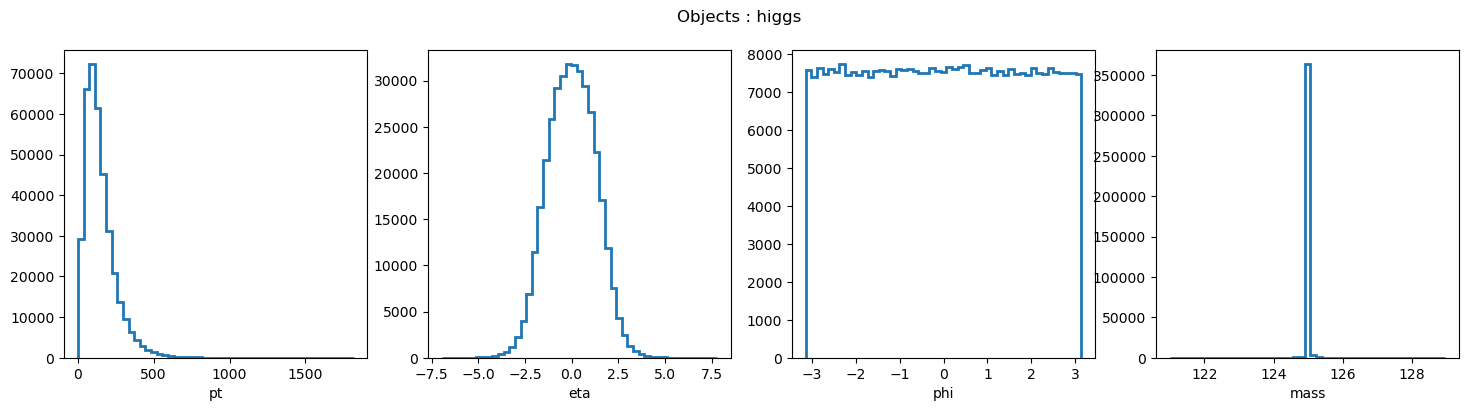

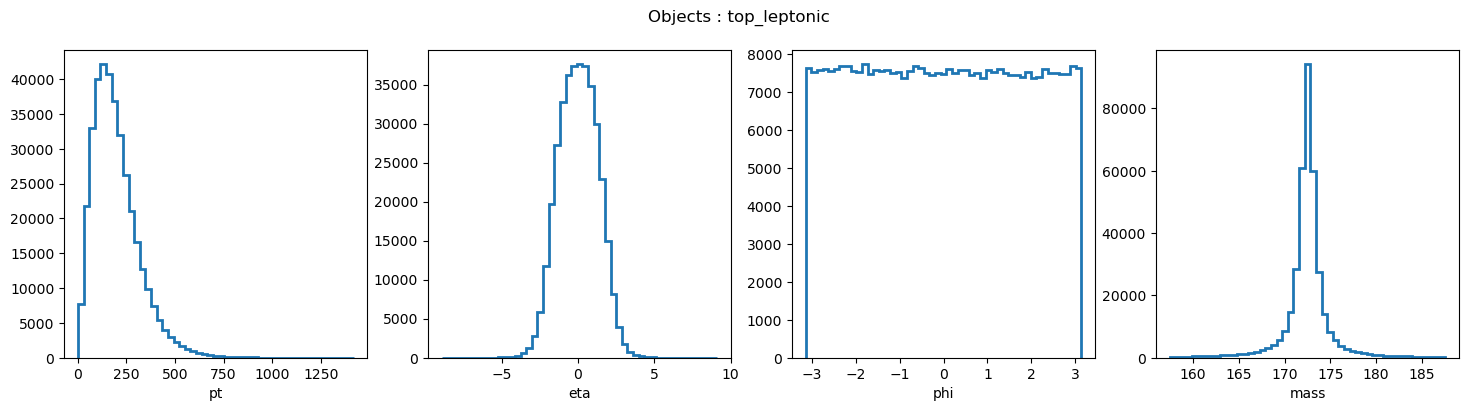

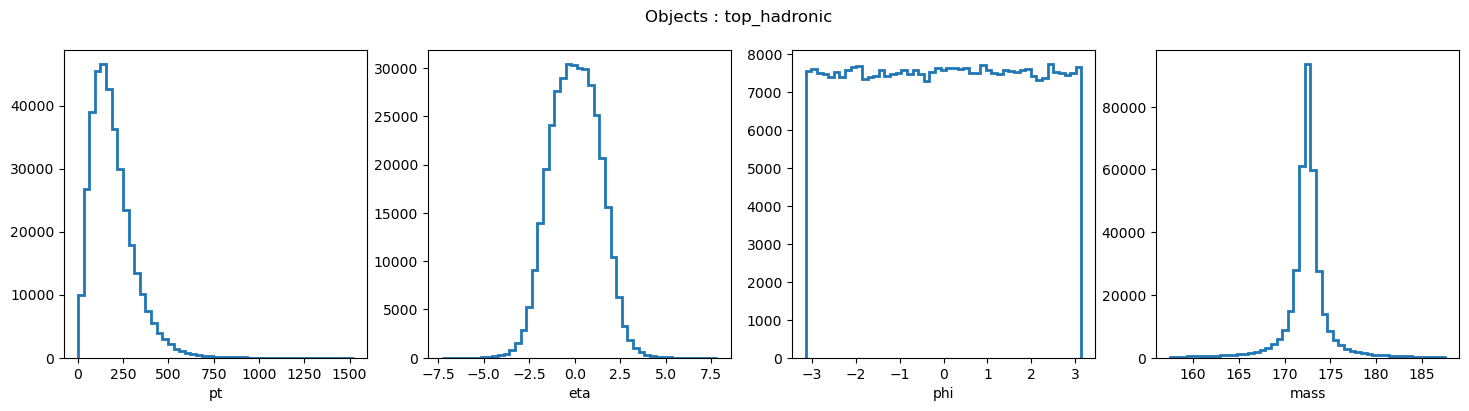

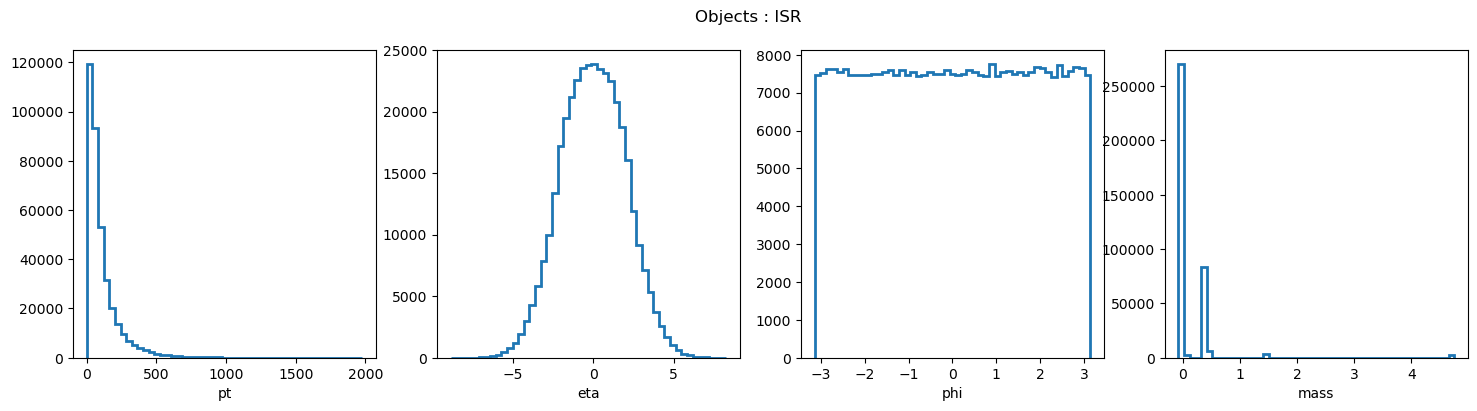

After preprocessing


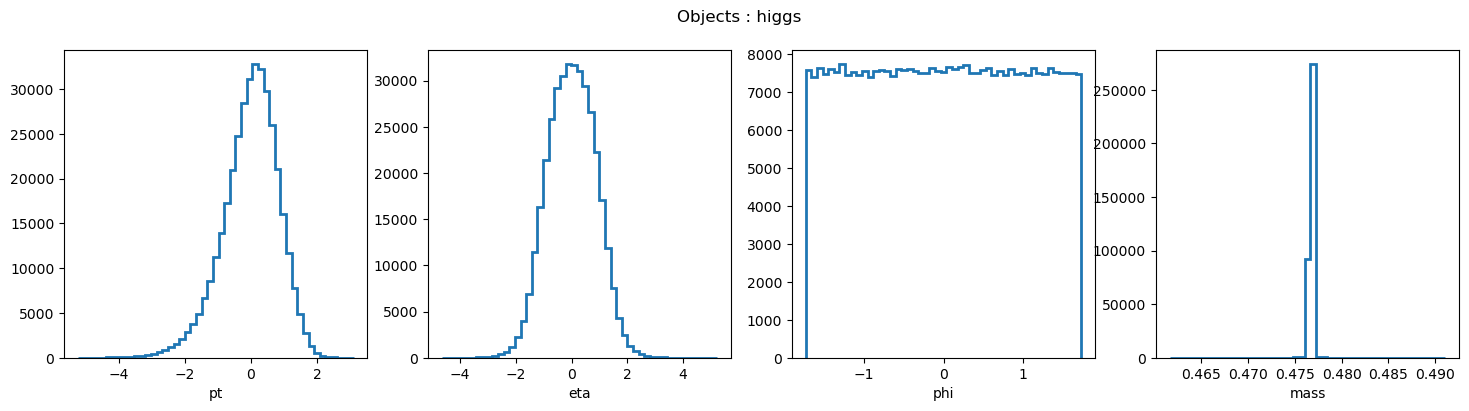

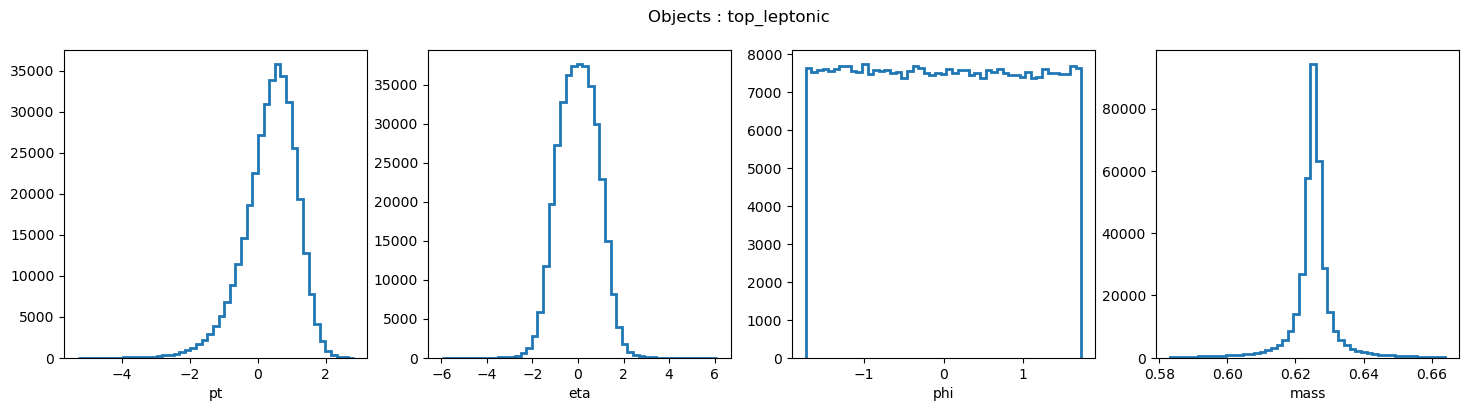

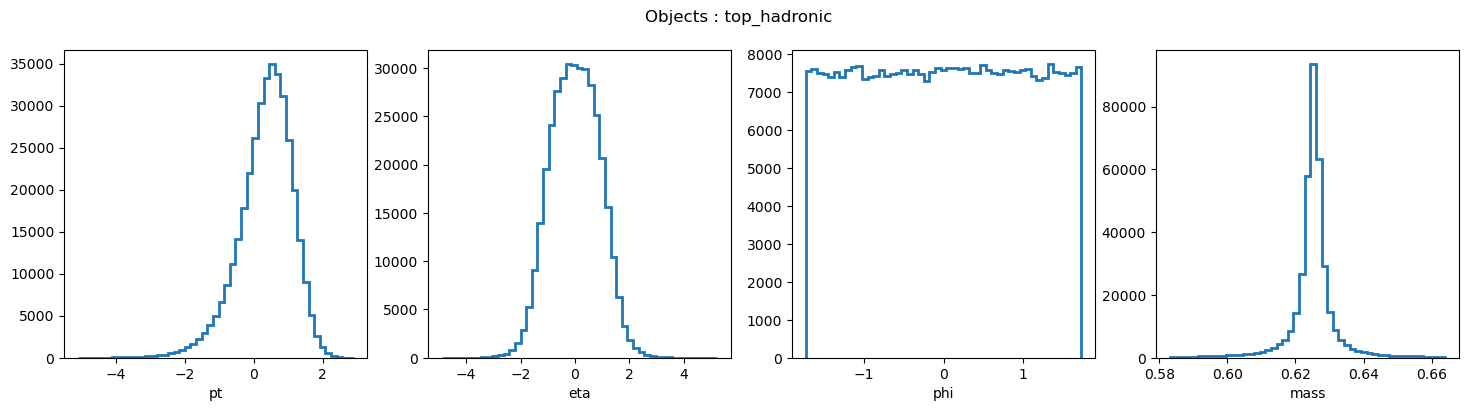

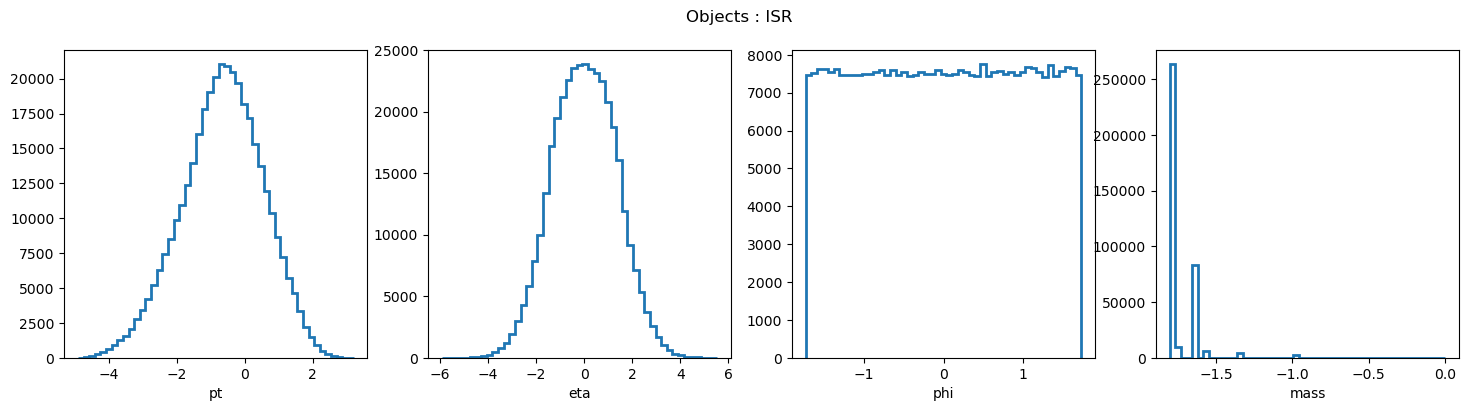

In [5]:
print ('Before preprocessing')
gen_dataset.plot(selection=True,raw=True)
print ('After preprocessing')
gen_dataset.plot(selection=True,raw=False)

In [6]:
loader_gen = DataLoader(
    gen_dataset,
    batch_size = 32,
)
batch = next(iter(loader_gen))

for obj,mask,sel in zip(batch['data'],batch['mask'],loader_gen.dataset.selection):
    print (sel,obj.shape,mask.shape)

higgs torch.Size([32, 1, 4]) torch.Size([32, 1])
top_leptonic torch.Size([32, 1, 4]) torch.Size([32, 1])
top_hadronic torch.Size([32, 1, 4]) torch.Size([32, 1])
ISR torch.Size([32, 1, 4]) torch.Size([32, 1])


In [7]:
reco_dataset = ttHRecoDataset(
    data = data,
    selection = [
        'lepton',
        'met',
        'jets',
    ],
    default_features = {
        'pt' : 0.,
        'eta' : 0.,
        'phi' : 0.,
        'm' : None,
        'btag' : None,
        'matched' : None,
        'prov' : None,
    },
    coordinates = 'cylindrical',
    apply_preprocessing = True,
    apply_boost = False,
    build = True,
    dtype = torch.float32,
)
print (reco_dataset)

Saving objects to /auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/dataset/tth_reco
Reco dataset with 369251 events
Containing the following tensors
boost   : data ([369251, 1, 3]), mask ([369251, 1])
          Mask exist    : [100.00%]
          Mask corr     : [True]
          Features      : ['pt', 'eta', 'phi']
          Selected for batches : False
jets    : data ([369251, 17, 3]), mask ([369251, 17])
          Mask exist    : [97.82%, 64.70%, 84.22%, 90.56%, 39.15%, 83.87%, 47.06%, 50.35%, 22.15%, 8.97%, 3.64%, 1.44%, 0.53%, 0.16%, 0.03%, <0.01%, <0.01%]
          Mask corr     : [True, True, True, True, True, True, True, False, False, False, False, False, False, False, False, False, False]
          Features      : ['pt', 'eta', 'phi']
          Selected for batches : True
lepton  : data ([369251, 1, 3]), mask ([369251, 1])
          Mask exist    : [100.00%]
          Mask corr     : [True]
          Features      : ['pt', 'eta', 'phi']
          Selected for batches : True
met

Before preprocessing


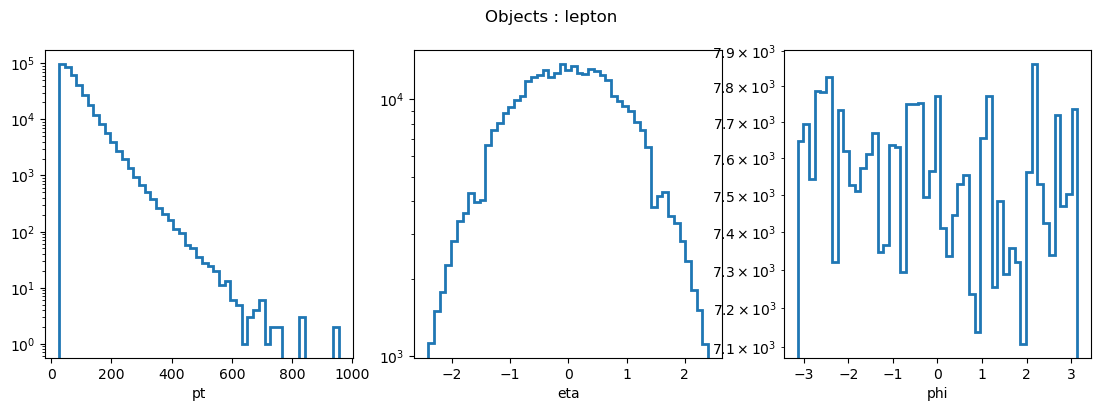

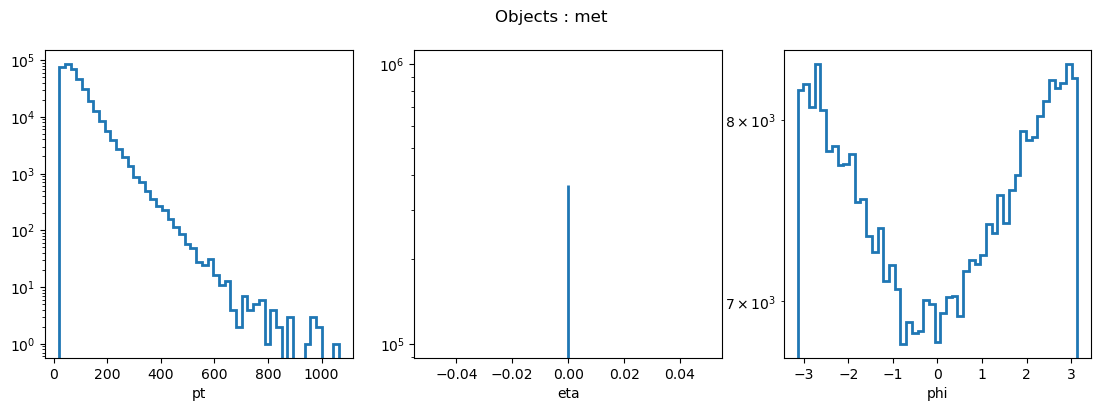

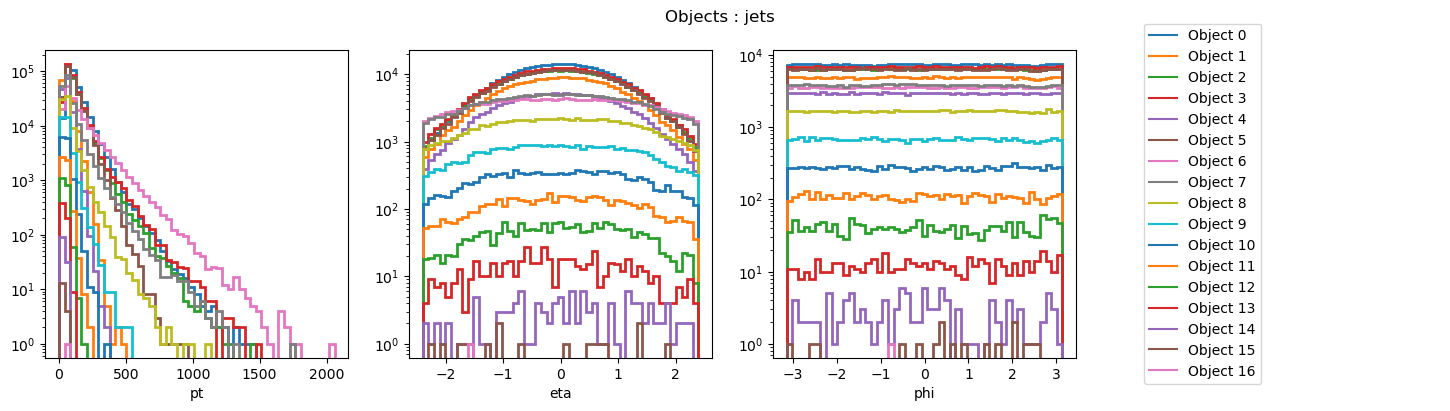

After preprocessing


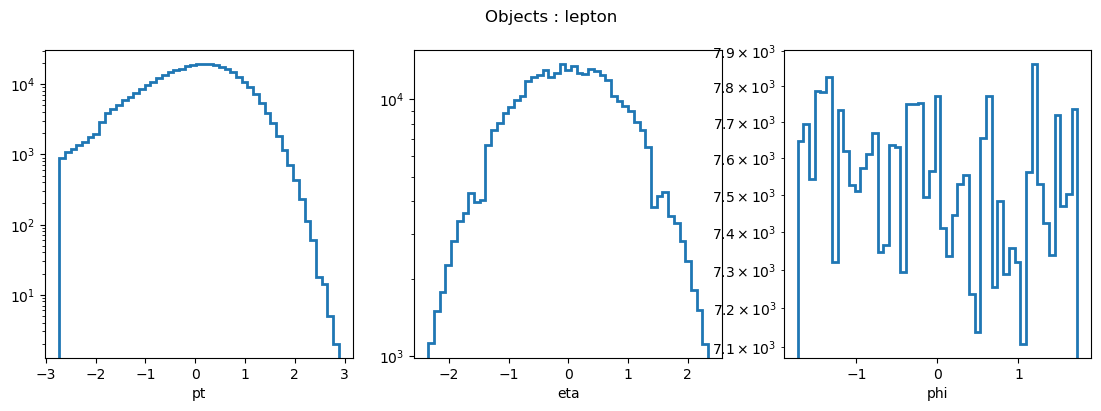

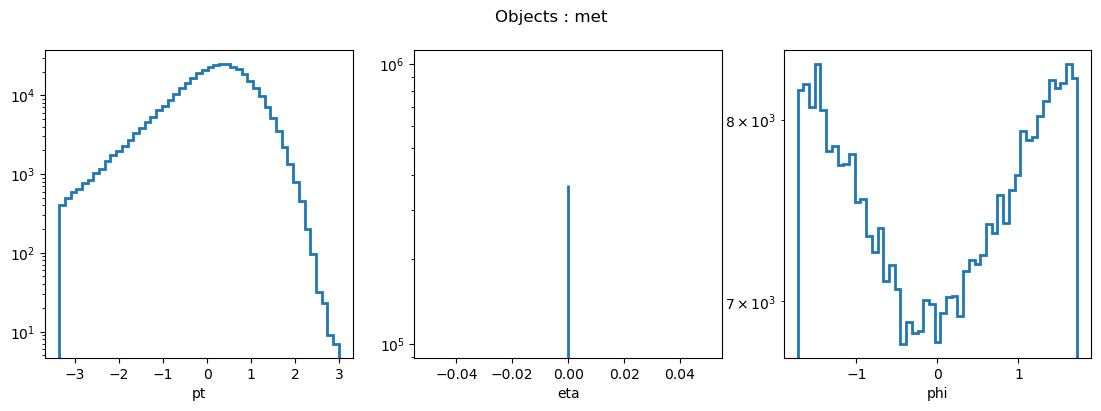

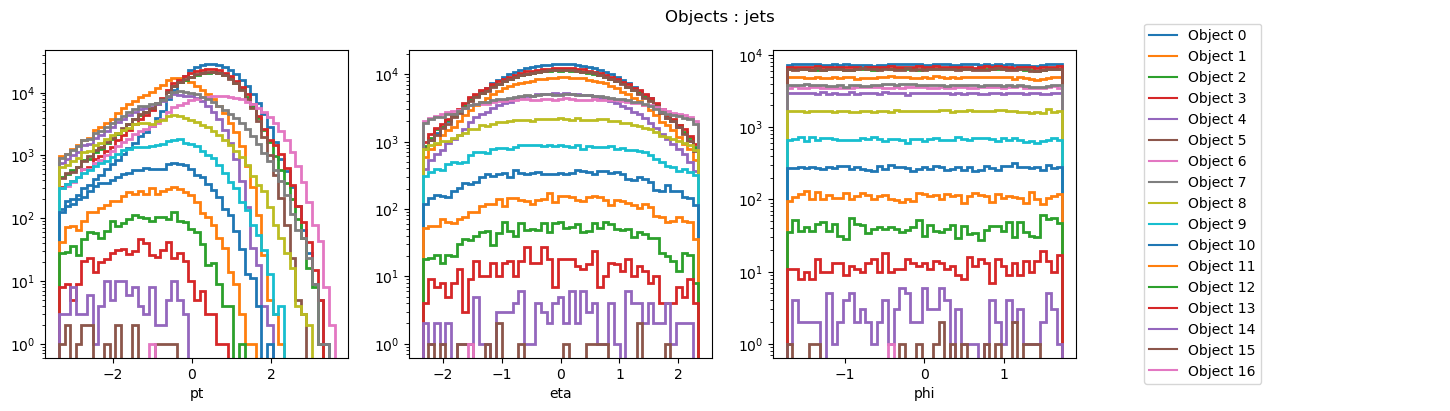

In [8]:
print ('Before preprocessing')
reco_dataset.plot(selection=True,raw=True,log=True)
print ('After preprocessing')
reco_dataset.plot(selection=True,raw=False,log=True)

In [9]:
loader_reco = DataLoader(
    reco_dataset,
    batch_size = 32,
)
batch = next(iter(loader_reco))

for obj,mask,sel in zip(batch['data'],batch['mask'],loader_reco.dataset.selection):
    print (sel,obj.shape,mask.shape)

lepton torch.Size([32, 1, 3]) torch.Size([32, 1])
met torch.Size([32, 1, 3]) torch.Size([32, 1])
jets torch.Size([32, 17, 3]) torch.Size([32, 17])


In [10]:
comb_dataset = CombinedDataset(
    gen_dataset = gen_dataset,
    reco_dataset = reco_dataset,
)
print (comb_dataset)

Combined dataset (extracting 369251 events of the following) :
Parton dataset with 369251 events
 Initial states pdgids : [21, 21]
 Final states pdgids   : [25, 6, -6, 21]
 Final states masses   : [125.25, 172.5, 172.5, 0.0]
Containing the following tensors
boost            : data ([369251, 1, 4]), mask ([369251, 1])
                   Mask exist    : [100.00%]
                   Mask corr     : [True]
                   Features      : ['x', 'y', 'z', 't']
                   Selected for batches : False
partons          : data ([369251, 7, 6]), mask ([369251, 7])
                   Mask exist    : [100.00%, 100.00%, 100.00%, 100.00%, 100.00%, 100.00%, 99.99%]
                   Mask corr     : [True, True, True, True, True, True, True]
                   Features      : ['pt', 'eta', 'phi', 'mass', 'pdgId', 'prov']
                   Selected for batches : False
leptons          : data ([369251, 2, 5]), mask ([369251, 2])
                   Mask exist    : [100.00%, 100.00%]
         

In [11]:
loader_comb = DataLoader(
    comb_dataset,
    batch_size = 256,
)
batch = next(iter(loader_comb))

print ('Reco')
for obj,mask,sel in zip(batch['reco']['data'],batch['reco']['mask'],loader_reco.dataset.selection):
    print (sel,obj.shape,mask.shape)
print ('Gen')
for obj,mask,sel in zip(batch['gen']['data'],batch['gen']['mask'],loader_gen.dataset.selection):
    print (sel,obj.shape,mask.shape)

Reco
lepton torch.Size([256, 1, 3]) torch.Size([256, 1])
met torch.Size([256, 1, 3]) torch.Size([256, 1])
jets torch.Size([256, 17, 3]) torch.Size([256, 17])
Gen
higgs torch.Size([256, 1, 4]) torch.Size([256, 1])
top_leptonic torch.Size([256, 1, 4]) torch.Size([256, 1])
top_hadronic torch.Size([256, 1, 4]) torch.Size([256, 1])
ISR torch.Size([256, 1, 4]) torch.Size([256, 1])


In [12]:
# Split dataset into training and validation
# Not randomly for reproducilibility, but just based on number

train_frac = 0.8
indices = torch.arange(len(comb_dataset))
sep = int(train_frac*len(comb_dataset))
train_indices = indices[:sep]
valid_indices = indices[sep:]

comb_dataset_train = torch.utils.data.Subset(comb_dataset,train_indices)
comb_dataset_valid = torch.utils.data.Subset(comb_dataset,valid_indices)
print (len(comb_dataset_train),len(comb_dataset_valid))

batch_size = 5000

loader_comb_train = DataLoader(
    comb_dataset_train,
    batch_size = batch_size,
    shuffle = True,
)
loader_comb_valid = DataLoader(
    comb_dataset_valid,
    batch_size = 10000,
    shuffle = False,
)

295400 73851


In [13]:
# Find some indices in the validation set with max number of jets
# To use in the sampling to see a maximum number of jets
count = ak.count(data['jets'].pt,axis=1).to_numpy()
mask_max = count == ak.max(count)
mask_valid = np.full(len(count),fill_value=False)
mask_valid[valid_indices] = True
idx_max = np.where(
    np.logical_and(mask_max,mask_valid)
)[0]
for i in idx_max:
    prov = data['jets'].prov[i]
    unique, counts = np.unique(prov, return_counts=True)
    print ('idx',i,', '.join([f'prov {u:.0f} x {c:.0f}' for u,c in zip(unique, counts)]))

idx 295637 prov -1 x 4, prov 1 x 2, prov 2 x 1, prov 4 x 1, prov 5 x 2
idx 295705 prov -1 x 3, prov 1 x 2, prov 2 x 1, prov 3 x 1, prov 4 x 1, prov 5 x 2
idx 296145 prov -1 x 5, prov 1 x 2, prov 2 x 1, prov 4 x 1, prov 5 x 1
idx 296278 prov -1 x 5, prov 1 x 1, prov 2 x 1, prov 3 x 1, prov 5 x 2
idx 296326 prov -1 x 5, prov 1 x 2, prov 2 x 1, prov 3 x 1, prov 5 x 1
idx 296365 prov -1 x 3, prov 1 x 2, prov 2 x 1, prov 3 x 1, prov 4 x 1, prov 5 x 2
idx 296457 prov -1 x 4, prov 1 x 2, prov 2 x 1, prov 3 x 1, prov 5 x 2
idx 296487 prov -1 x 5, prov 1 x 2, prov 3 x 1, prov 5 x 2
idx 296655 prov -1 x 4, prov 1 x 2, prov 2 x 1, prov 3 x 1, prov 5 x 2
idx 296756 prov -1 x 4, prov 1 x 2, prov 2 x 1, prov 3 x 1, prov 4 x 1, prov 5 x 1
idx 297058 prov -1 x 4, prov 1 x 1, prov 2 x 1, prov 3 x 1, prov 4 x 1, prov 5 x 2
idx 297284 prov -1 x 8, prov 1 x 1, prov 3 x 1
idx 297289 prov -1 x 5, prov 1 x 2, prov 3 x 1, prov 4 x 1, prov 5 x 1
idx 297315 prov -1 x 6, prov 1 x 1, prov 3 x 1, prov 5 x 2
idx 29

In [14]:
from memflow.transfer_flow.transfer_flow_model import TransferFlow

model = TransferFlow(
    embed_dim = 64,
    embed_act = nn.GELU,
    n_gen_particles_per_type = gen_dataset.number_particles_per_type,
    gen_particle_type_names = gen_dataset.selection,
    gen_input_features_per_type = gen_dataset.input_features,
    n_reco_particles_per_type = reco_dataset.number_particles_per_type,
    reco_particle_type_names = reco_dataset.selection,
    reco_input_features_per_type = reco_dataset.input_features,
    flow_input_features = [
        ['pt','eta','phi'], # leptons
        ['pt','phi'],       # met
        ['pt','eta','phi'], # jets
    ],
    reco_mask_corr = reco_dataset.correlation_mask,
    gen_mask_corr = gen_dataset.correlation_mask,
    transformer_args = {
        'nhead' : 8,
        'num_encoder_layers' : 6, 
        'num_decoder_layers' : 6, 
        'dim_feedforward' : 256, 
        'dropout' : 0., 
        'activation' : 'gelu', 
    },
    flow_args = {
        'bins' : 16,
        'transforms' : 5,
        'randperm' : True,
        'passes' : 2,
        # 'univariate'
        # 'univariate_kwargs' : {"bound": 1},
        'hidden_features' : [64] * 5,   
    },
    onehot_encoding = True,
)

batch = next(iter(loader_comb))
print (model(batch))

print (model)

(tensor([[5.0675, 2.9160, 2.4617,  ..., 0.0000, 0.0000, 0.0000],
        [4.3077, 2.2968, 6.3335,  ..., 0.0000, 0.0000, 0.0000],
        [2.8031, 4.6609, 3.2110,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [3.1326, 3.1390, 3.0972,  ..., 0.0000, 0.0000, 0.0000],
        [3.4918, 2.2196, 5.2075,  ..., 0.0000, 0.0000, 0.0000],
        [6.3809, 5.5462, 3.2578,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<NegBackward0>), tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.]]))
TransferFlow(
  (gen_embeddings): ModuleList(
    (0-3): 4 x Sequential(
      (0): Linear(in_features=4, out_features=64, bias=True)
      (1): GELU(approximate='none')
    )
  )
  (reco_embeddings): ModuleList(
    (0-2): 3 x Sequential(
      (0): Linear(in_features=3, out_features=64, bias=True)
      (1): GE

In [15]:
##### Parameters #####
epochs = 100
steps_per_epoch_train = math.ceil(len(comb_dataset_train)/loader_comb_train.batch_size)
# steps_per_epoch_valid = math.ceil(len(dataset_valid)/loader_valid.batch_size)

print (f'Training   : Batch size = {loader_comb.batch_size} => {steps_per_epoch_train} steps per epoch')
# print (f'Validation : Batch size = {loader_valid.batch_size} => {steps_per_epoch_valid} steps per epoch')
##### Optimizer #####
optimizer = optim.RAdam(model.parameters(), lr=1e-3, weight_decay=1e-5)
model.set_optimizer(optimizer)

##### Scheduler #####
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer = optimizer, 
    max_lr = 1e-3, 
    epochs = epochs, 
    steps_per_epoch = steps_per_epoch_train, 
    pct_start = 0.20, 
    anneal_strategy='cos', 
    cycle_momentum=True, 
    base_momentum=0.85, 
    max_momentum=0.95, 
    div_factor=1e3, 
    final_div_factor=1e5,
)
model.set_scheduler_config(
    {
        'scheduler' : scheduler,
        'interval' : 'step' if isinstance(scheduler,optim.lr_scheduler.OneCycleLR) else 'epoch',
        'frequency' : 1,
        'monitor' : 'val/loss',
        'strict' : True,
        'name' : 'scheduler',
    }
)

##### Callbacks #####
# from callbacks import MomentumPredictorCallback, HistoryCallback
sampling = SamplingCallback(
    comb_dataset = comb_dataset,
    idx_to_monitor = [295705,29741,302151],
    N_sample = 5000, 
    frequency = 1,
    raw = True,
    bins = 25,
    log = False,
)

callbacks = [
    L.pytorch.callbacks.LearningRateMonitor(logging_interval='epoch'),
    L.pytorch.callbacks.ModelSummary(max_depth=2),
    sampling,
] 

##### Logger #####
logger = pl_loggers.CometLogger(
    save_dir = '../comet_logs',
    project_name = 'mem-flow-tth',
    experiment_name = 'model',
    offline = False,
) 
logger.log_graph(model)
# logger.log_hyperparams()
# logger.experiment.log_code(folder='../src/')
logger.experiment.log_notebook(filename=globals()['__session__'],overwrite=True)

##### Trainer #####
trainer = L.Trainer(    
    min_epochs = 5,
    max_epochs = epochs,
    callbacks = callbacks,
    devices = 'auto',
    accelerator = accelerator,
    logger = logger,
    log_every_n_steps = steps_per_epoch_train,
)
##### Fit #####
trainer.fit(
    model = model, 
    train_dataloaders = loader_comb_train,
    val_dataloaders = loader_comb_valid,
)



Training   : Batch size = 256 => 60 steps per epoch


CometLogger will be initialized in online mode
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn, torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/florianbury/mem-flow-tth/9301d8b7d3bf44609b515f4c2b1c7402

/home/ucl/cp3/fbury/scratch/anaconda3/envs/mem-flow/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/ucl/cp3/fbury/scratch/anaconda3/envs/mem-flow/ ...
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` call

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/ucl/cp3/fbury/scratch/anaconda3/envs/mem-flow/lib/python3.10/site-packages/torch/nn/modules/transformer.py:380: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /opt/conda/conda-bld/pytorch_1699449181202/work/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))
Exception ignored in: <function tqdm.__del__ at 0x7f7bc1a717e0>
Traceback (most recent call last):
  File "/home/ucl/cp3/fbury/scratch/anaconda3/envs/mem-flow/lib/python3.10/site-packages/tqdm/std.py", line 1147, in __del__
    def __del__(self):
KeyboardInterrupt: 
COMET WARNING: Failing to save the matplotlib figure
/home/ucl/cp3/fbury/scratch/anaconda3/envs/mem-flow/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
COMET INFO: --------------------------------------

Error in callback <function _draw_all_if_interactive at 0x7f7c87c27250> (for post_execute), with arguments args (),kwargs {}:


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f7cc1a4ed70>>
Traceback (most recent call last):
  File "/home/ucl/cp3/fbury/scratch/anaconda3/envs/mem-flow/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f7cc1a4ed70>>
Traceback (most recent call last):
  File "/home/ucl/cp3/fbury/scratch/anaconda3/envs/mem-flow/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 

KeyboardInterrupt



Error in callback <function flush_figures at 0x7f7ba7116c20> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt



In [16]:
# torch.save(model,'model.pt')

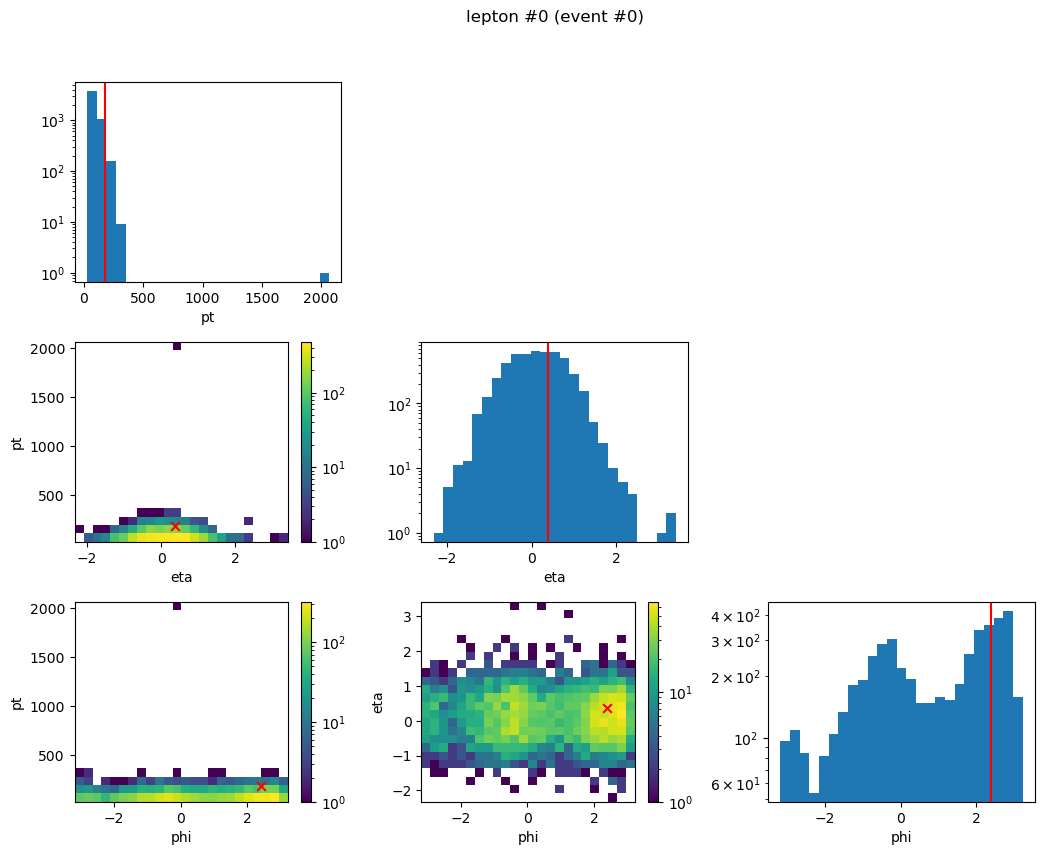

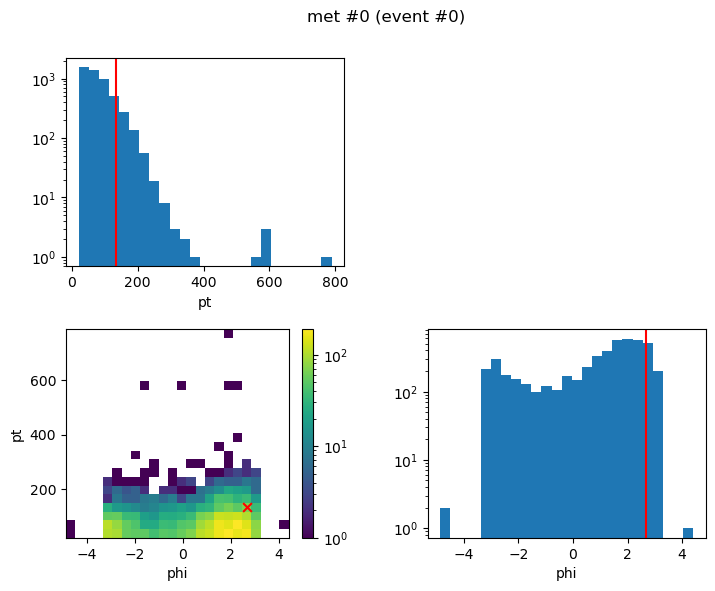

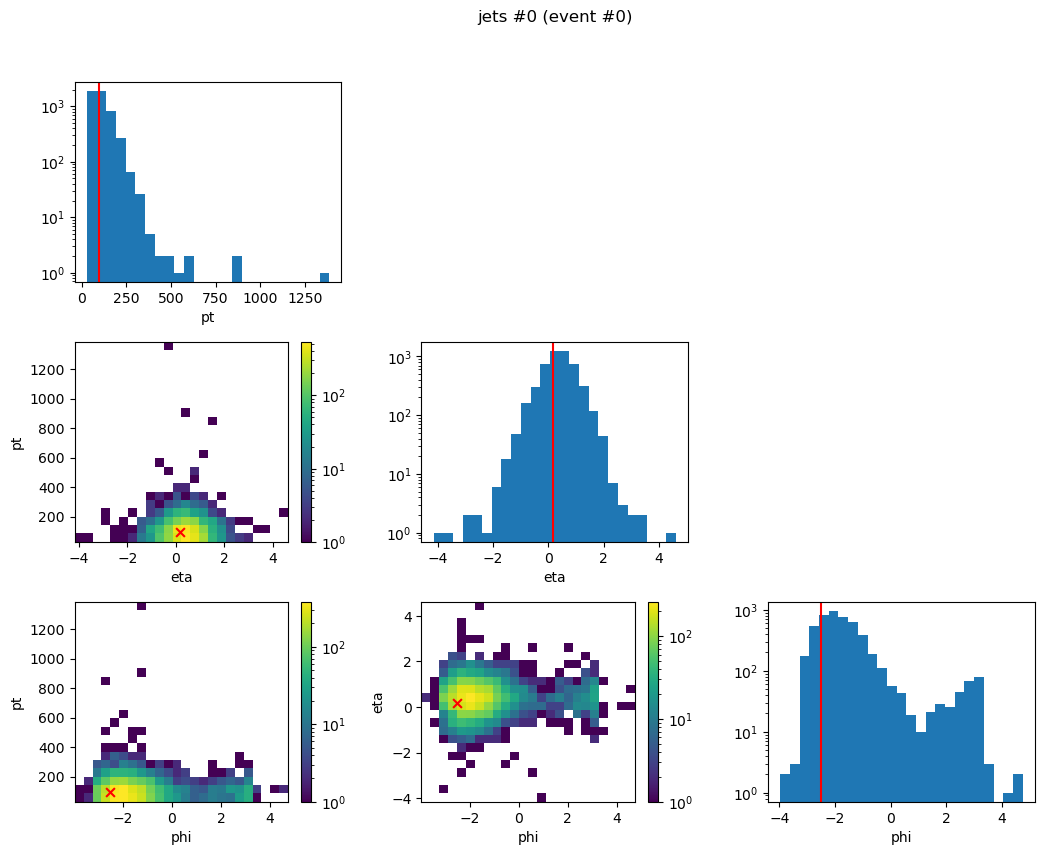

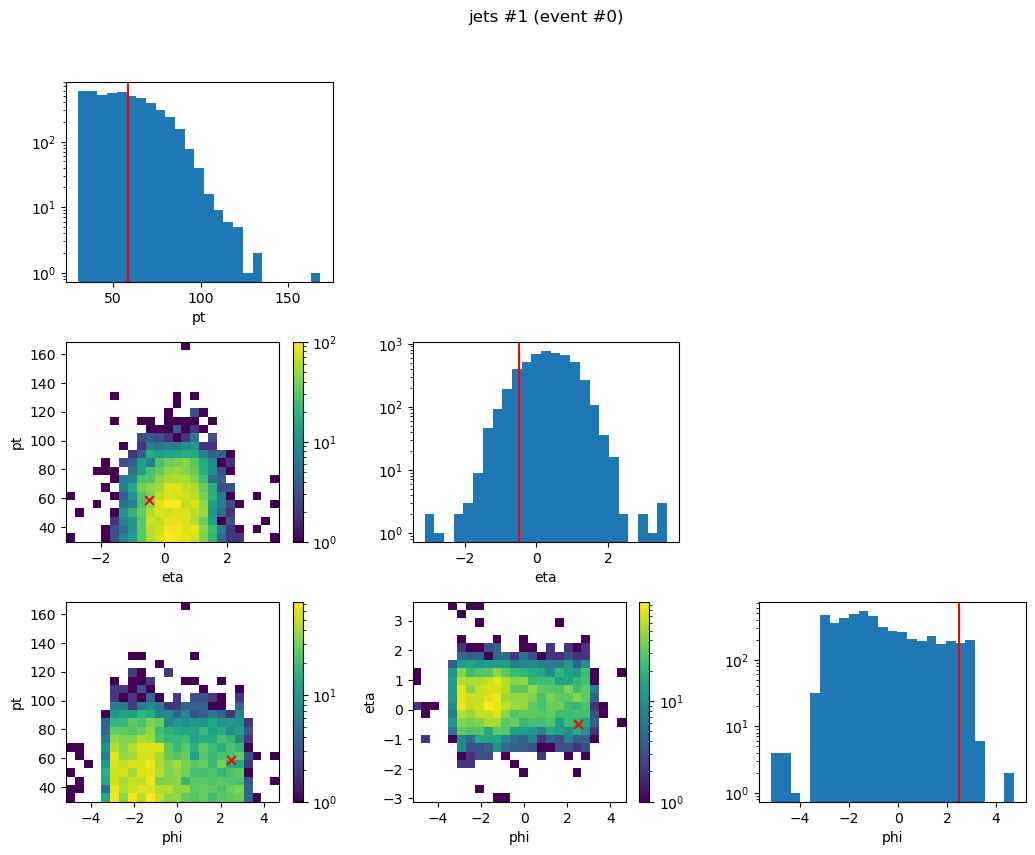

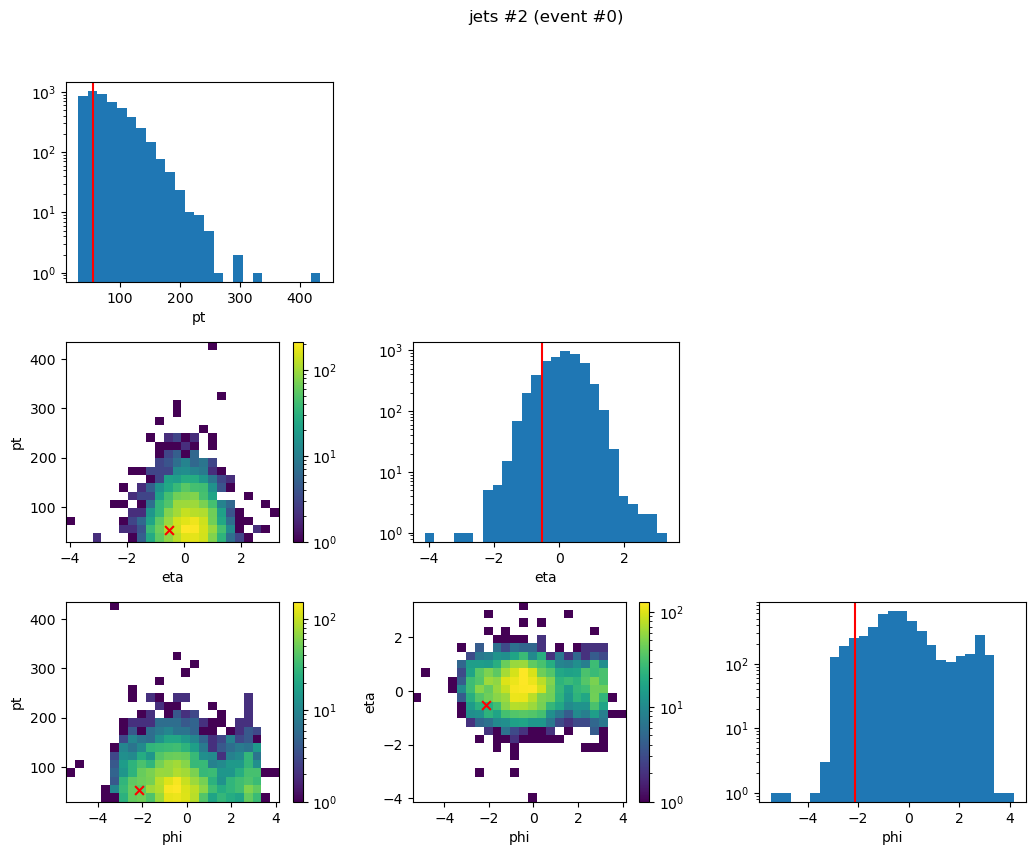

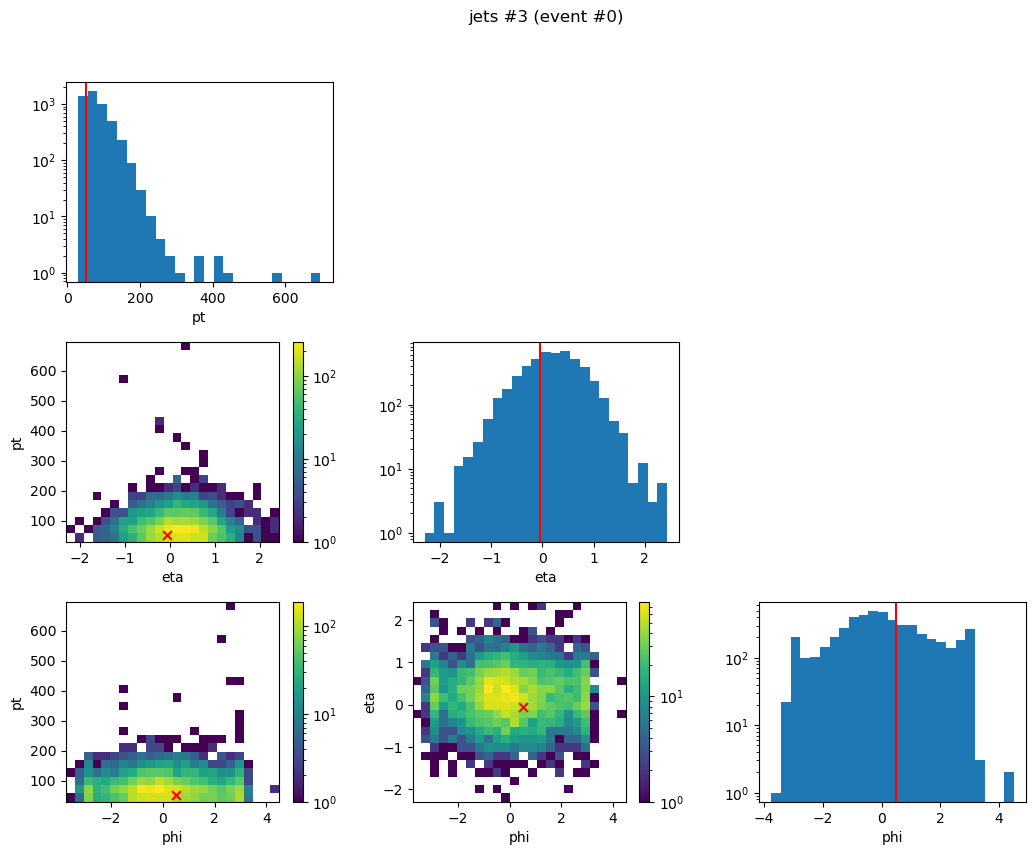

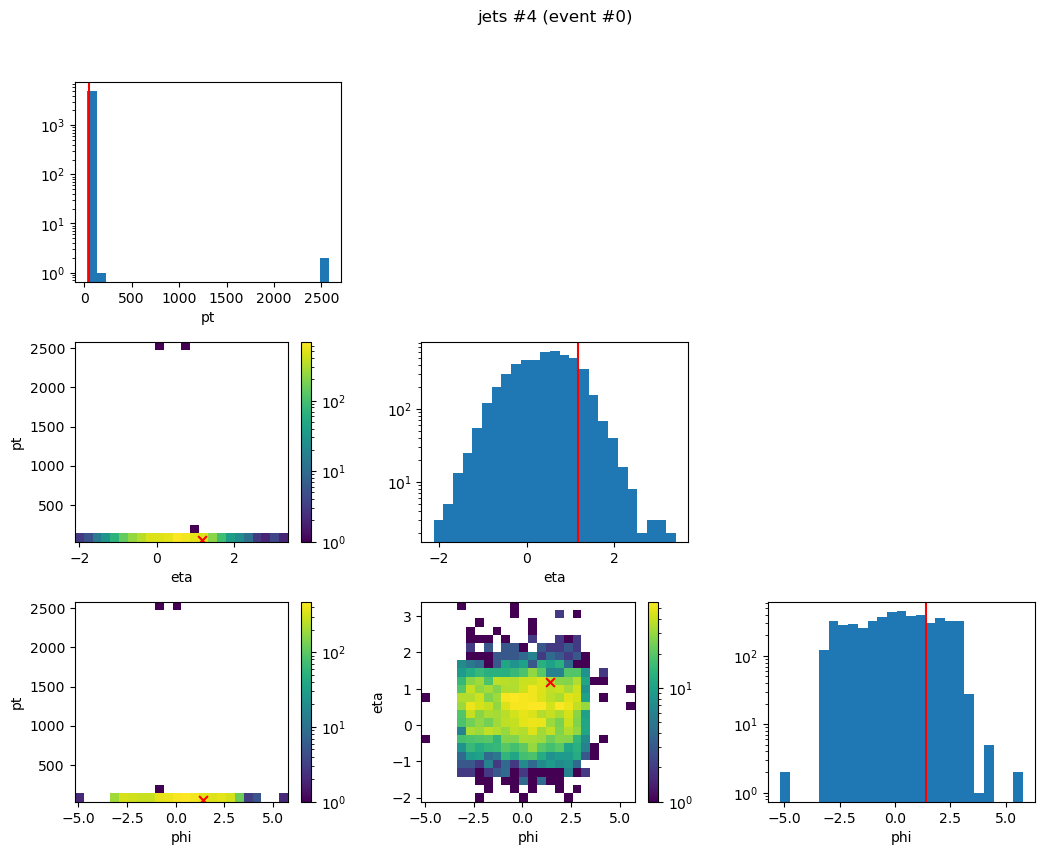

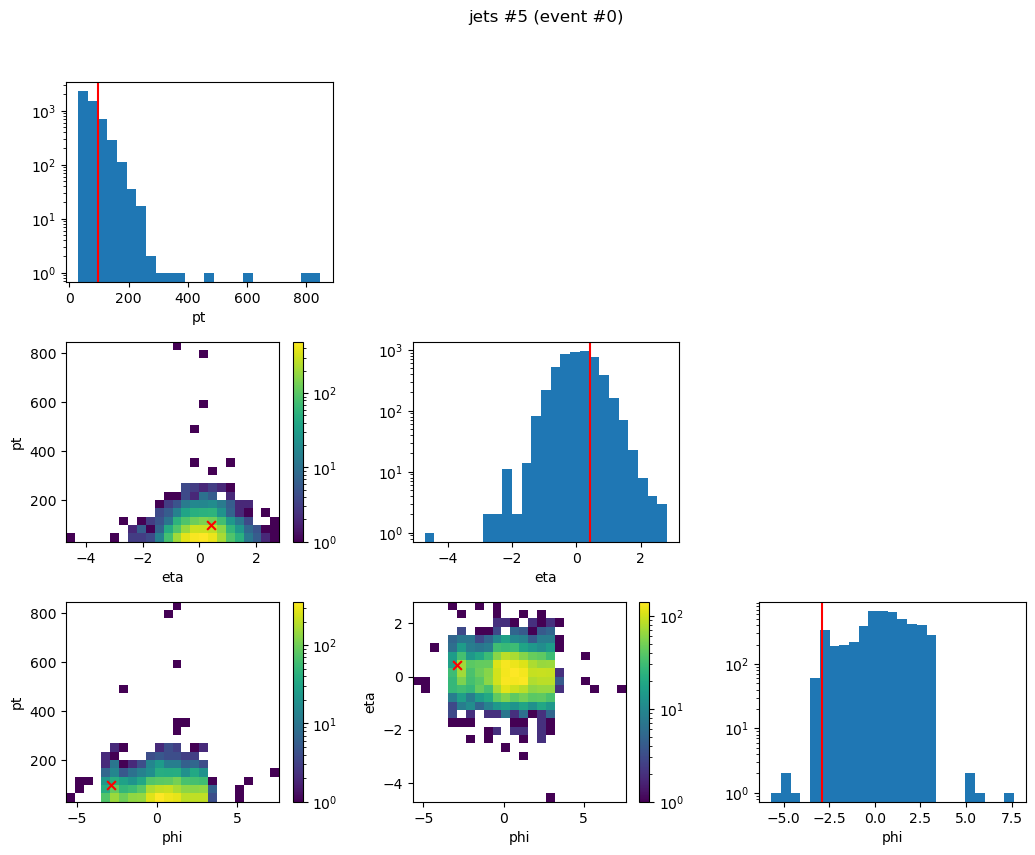

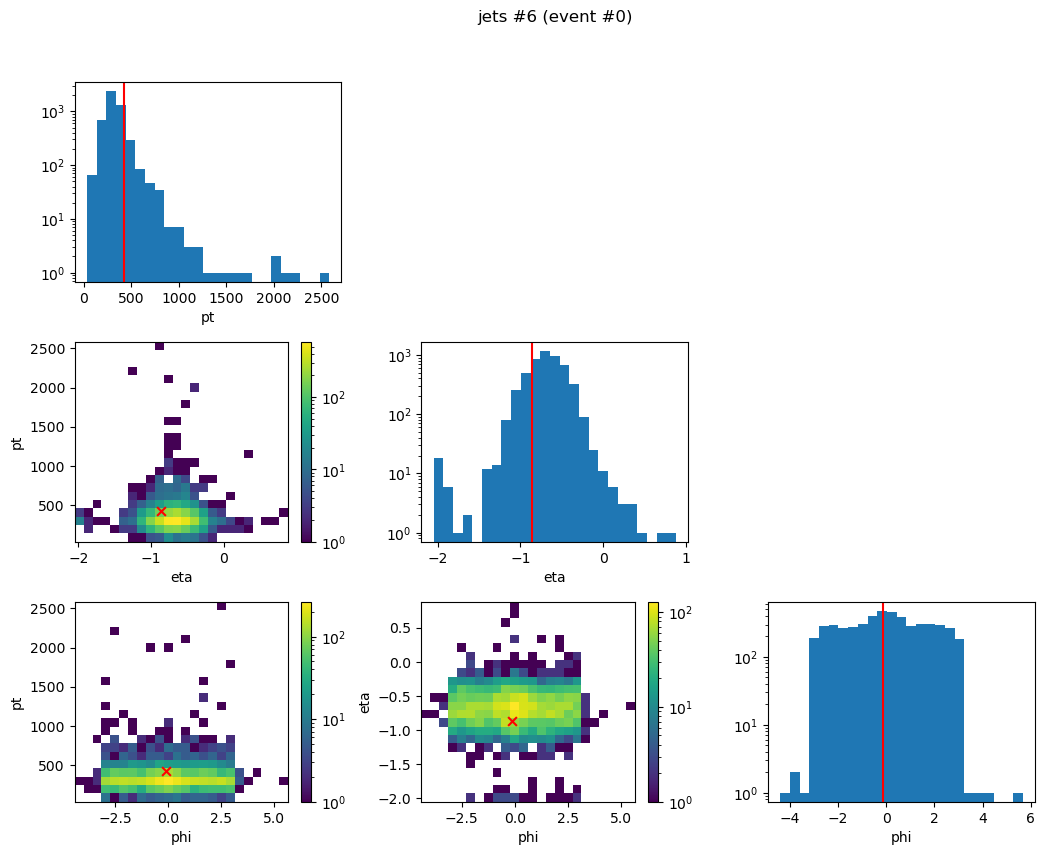

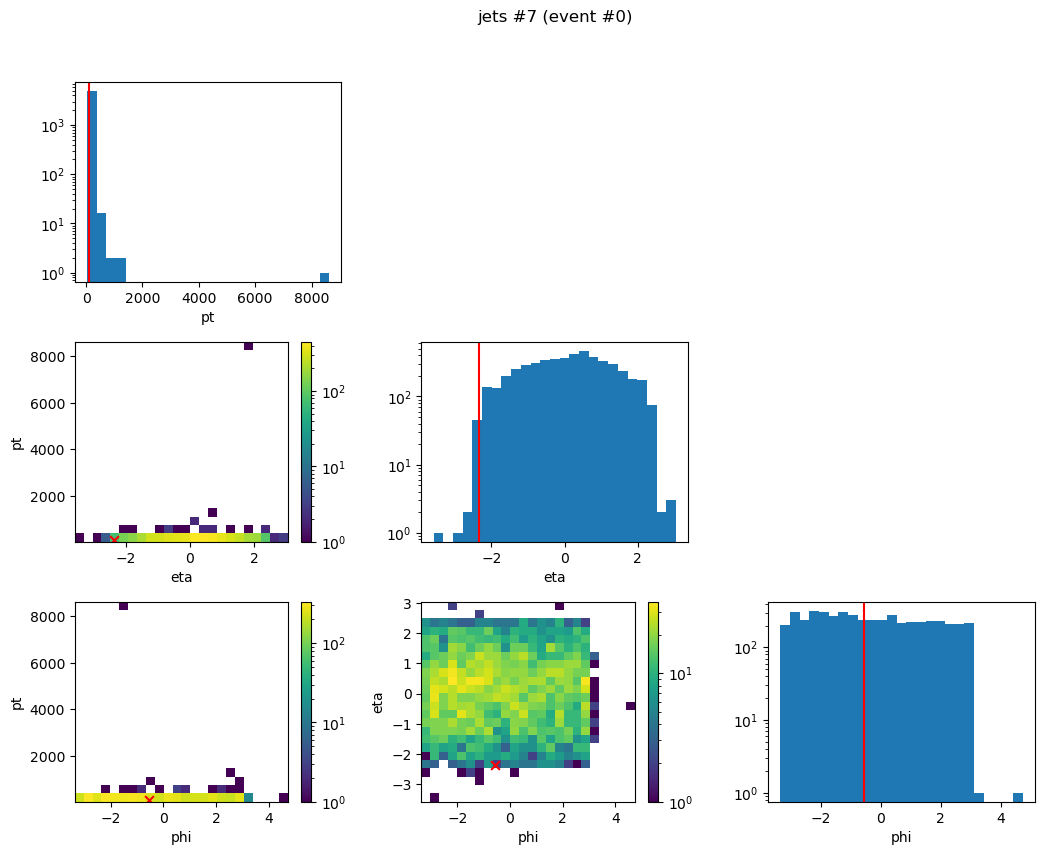

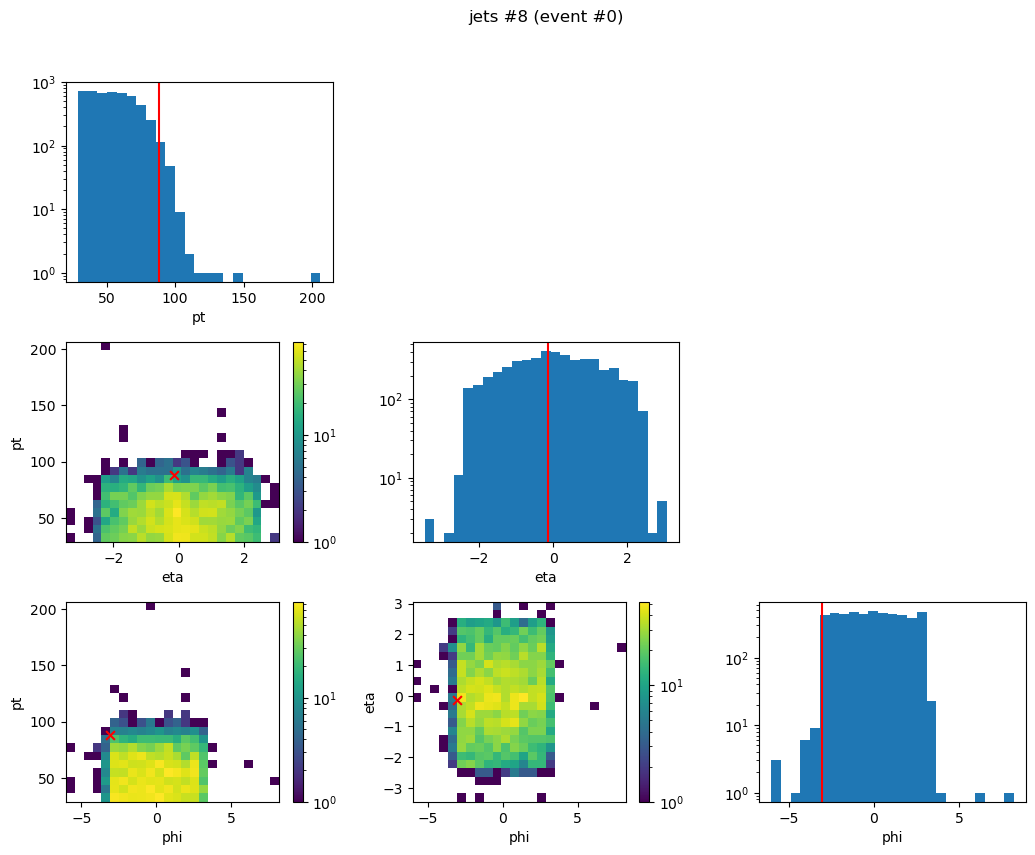

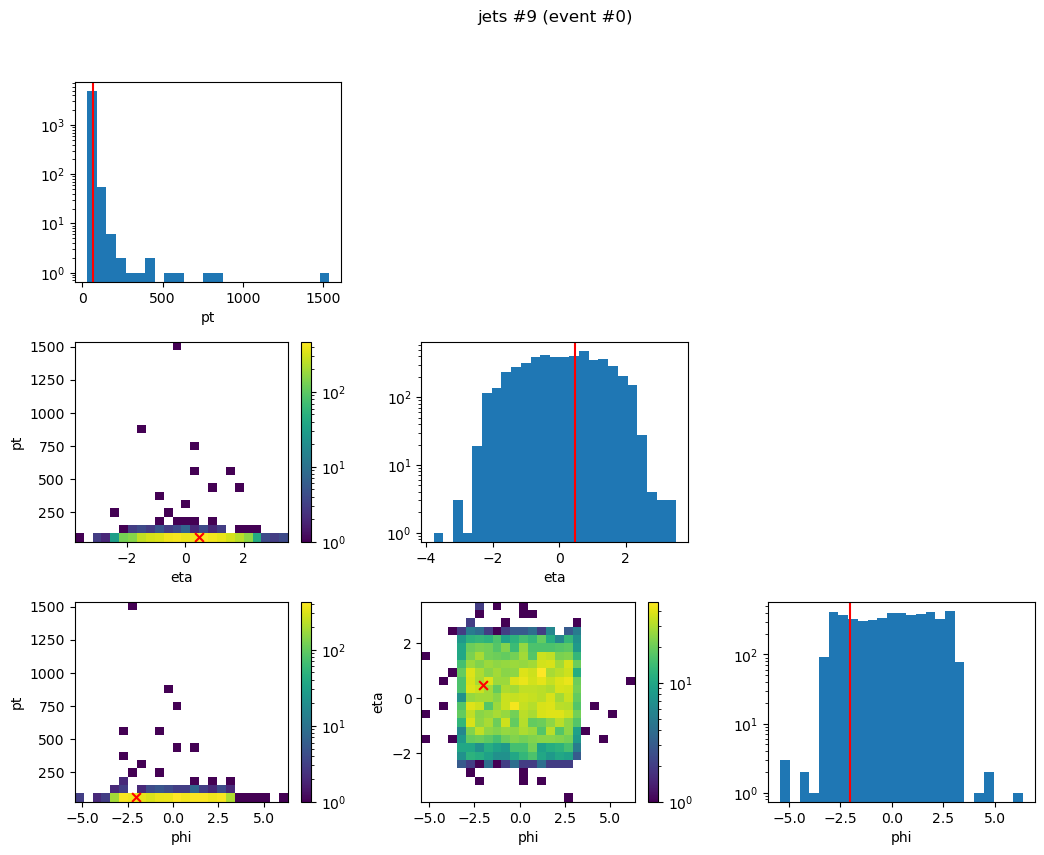

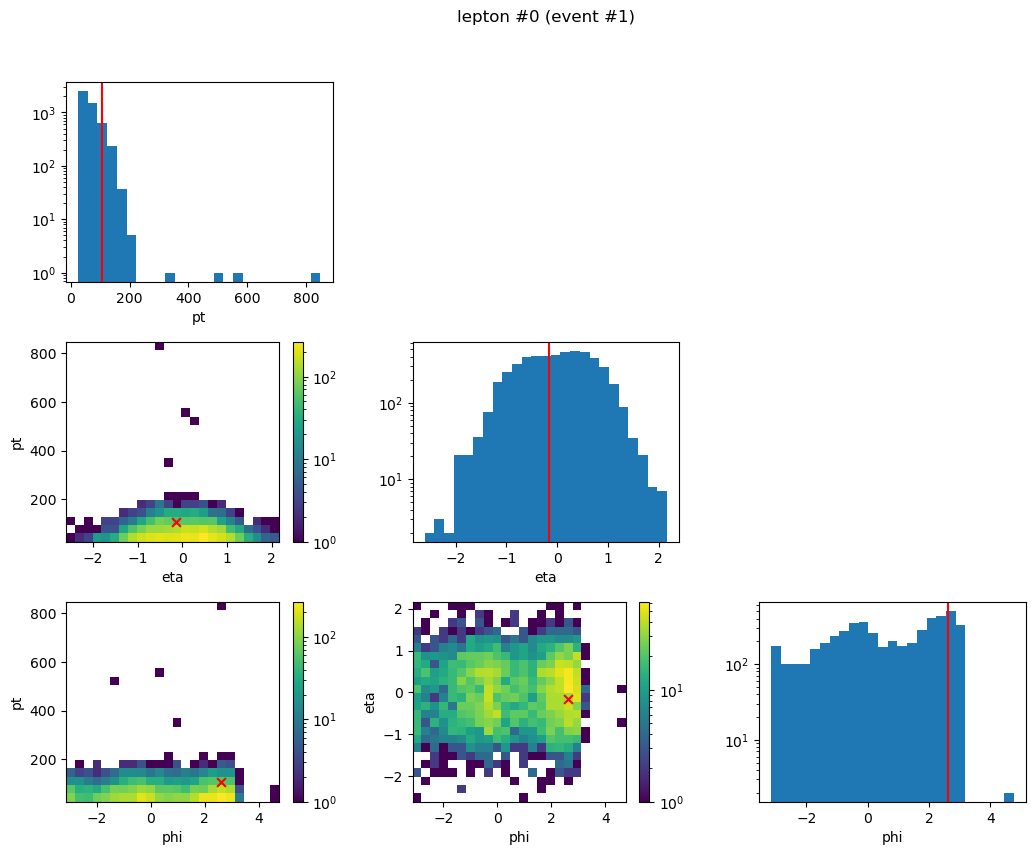

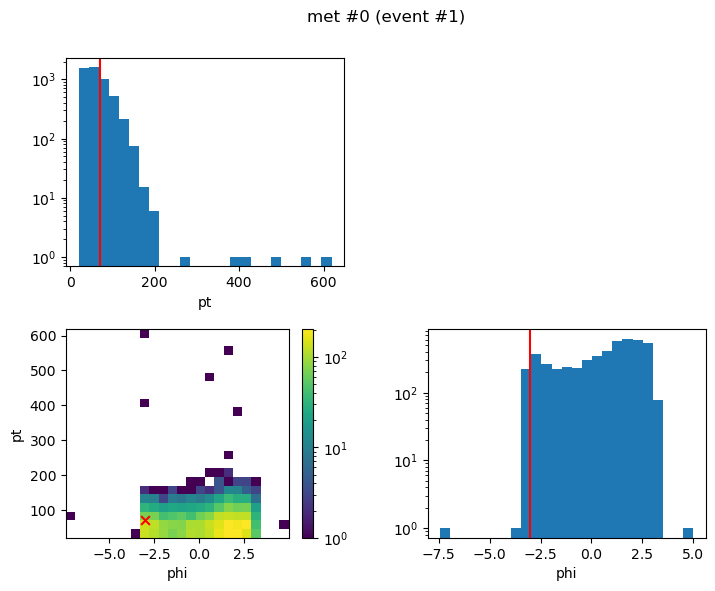

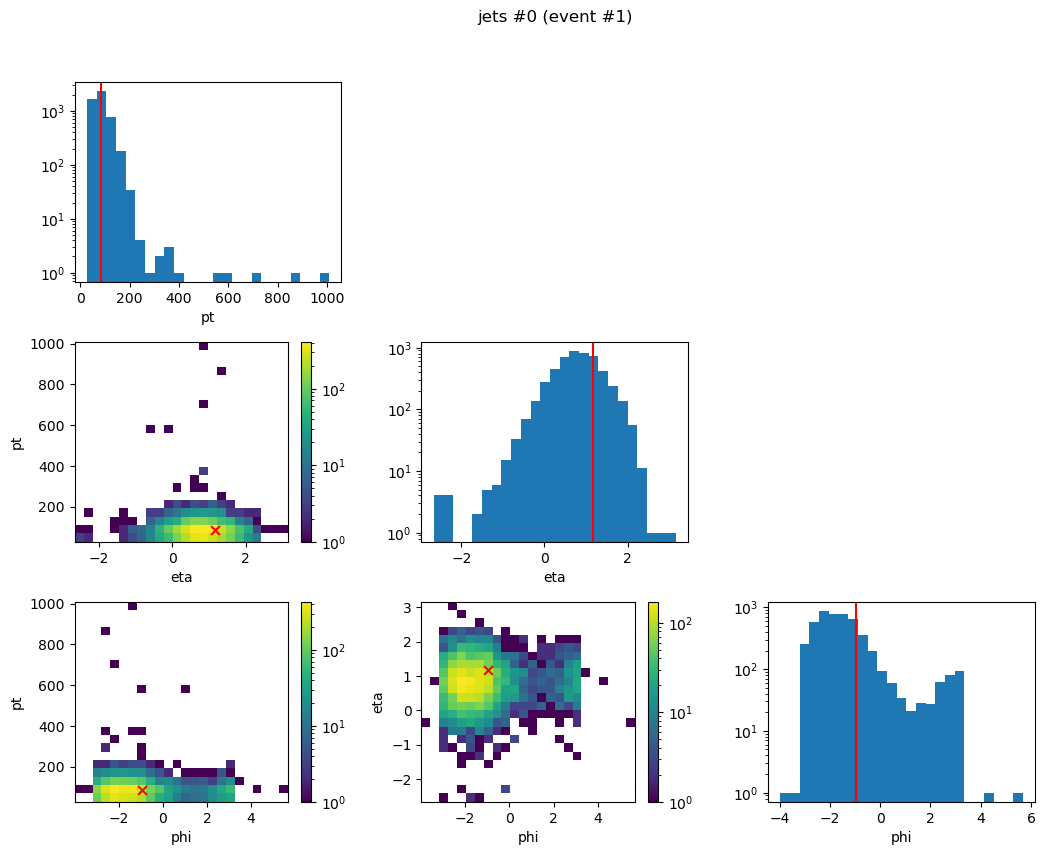

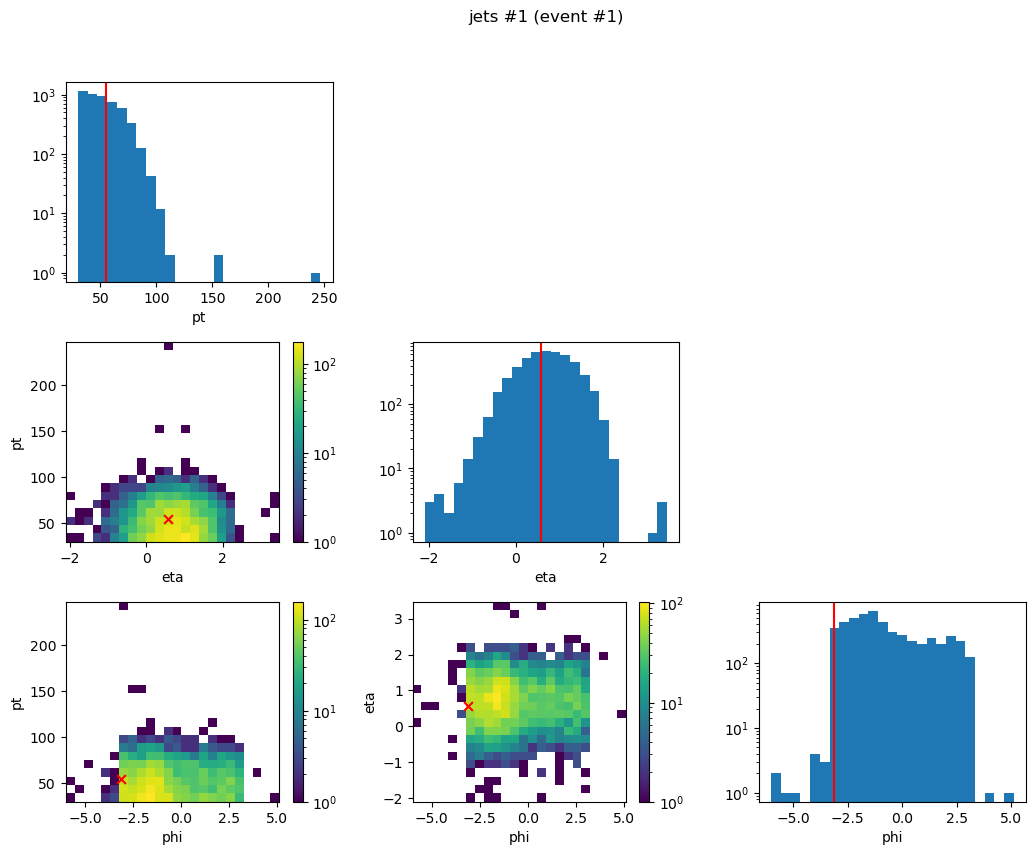

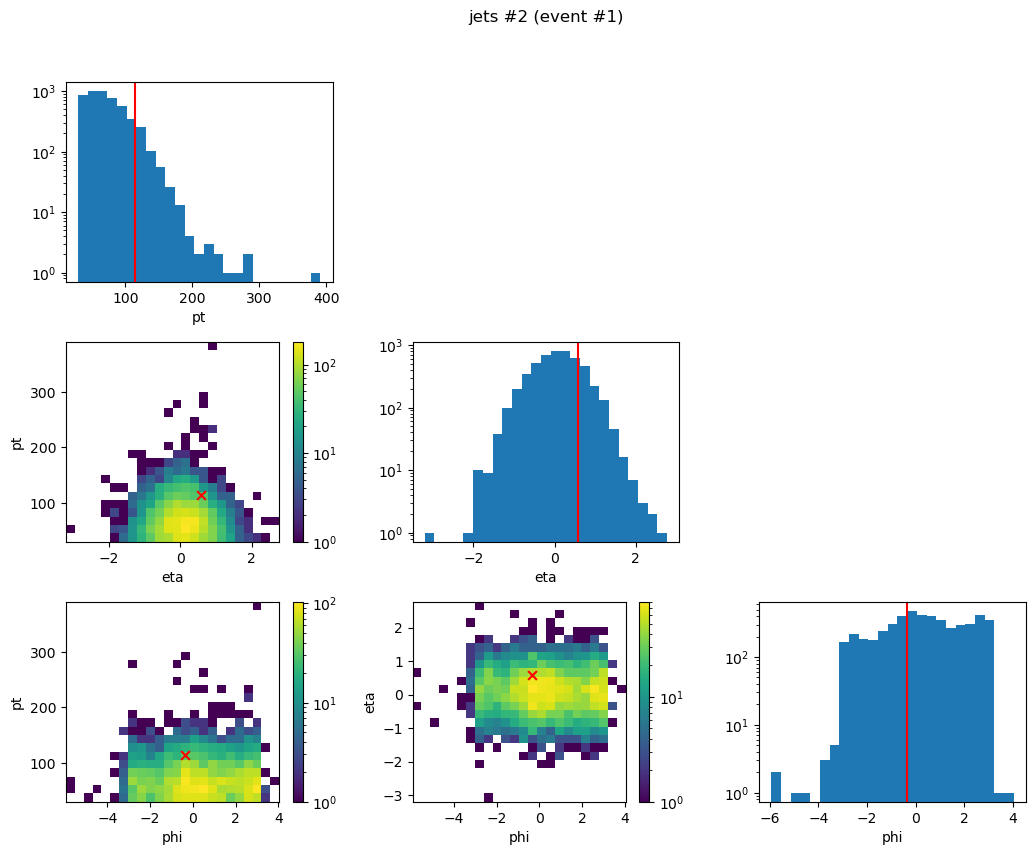

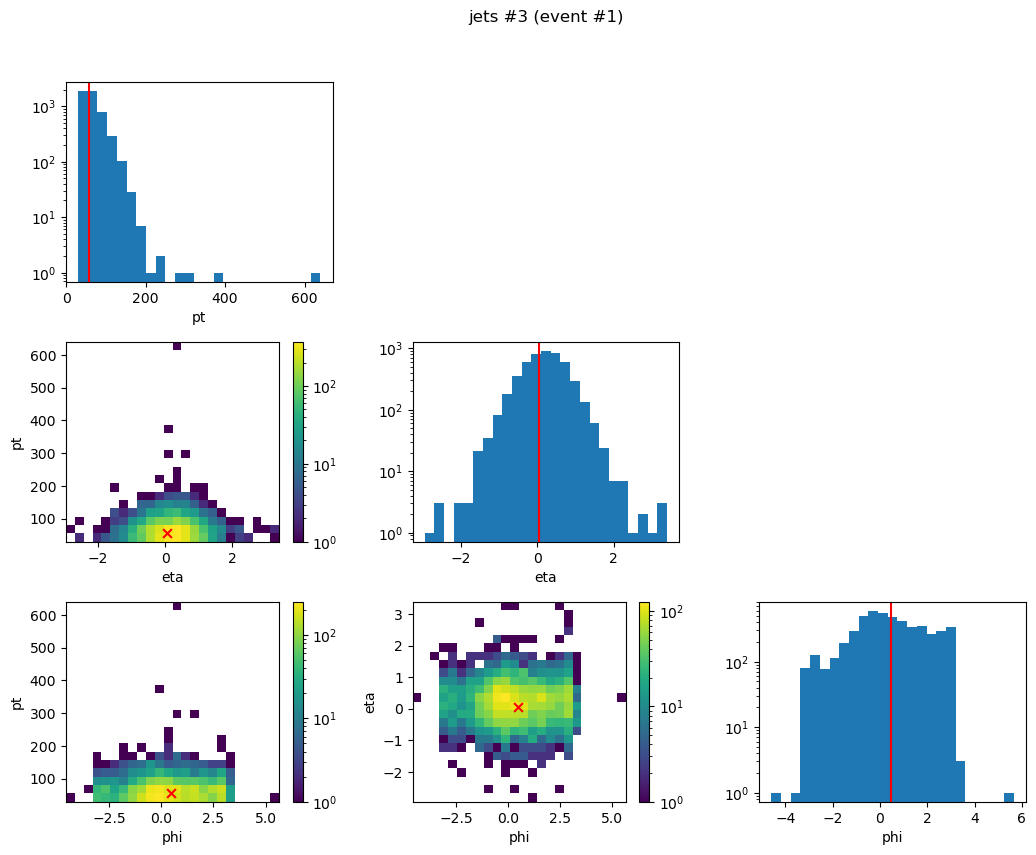

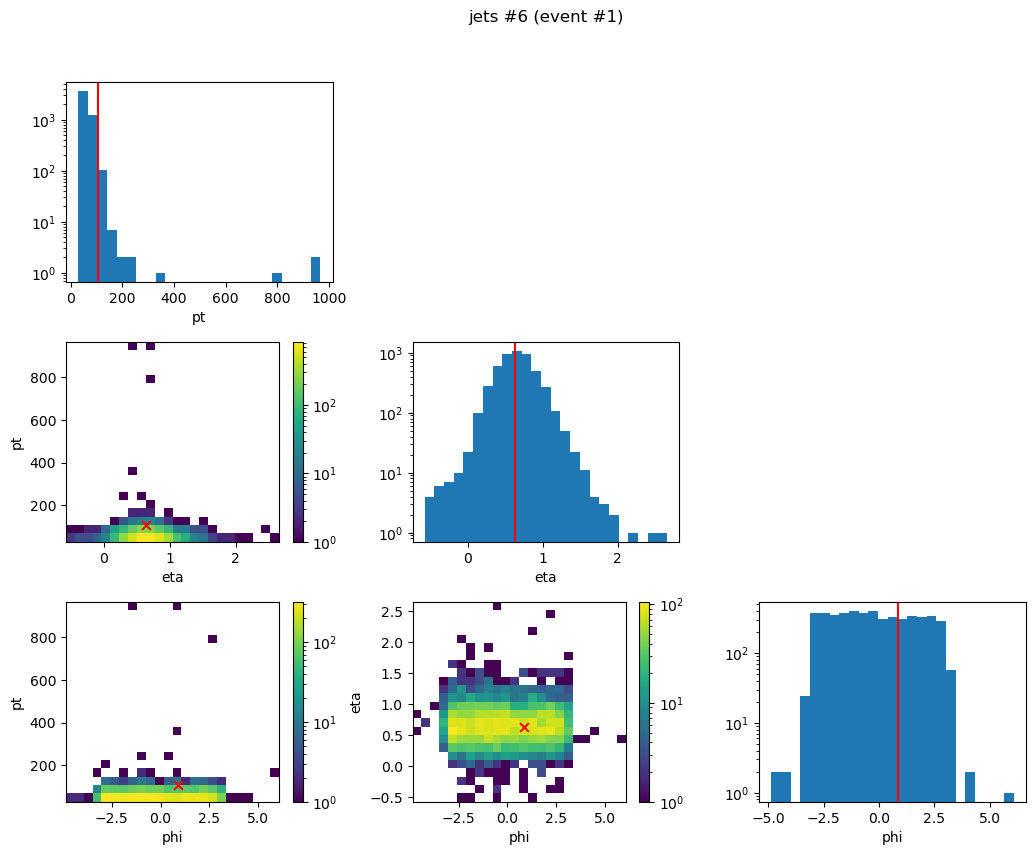

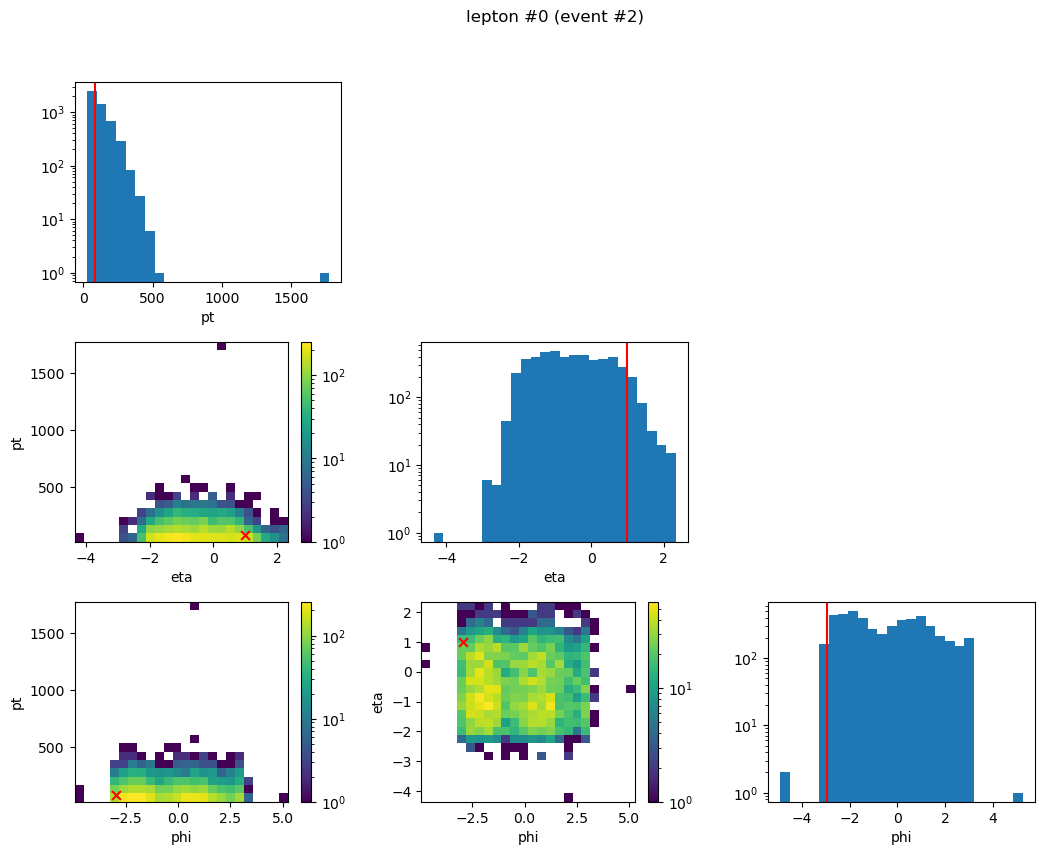

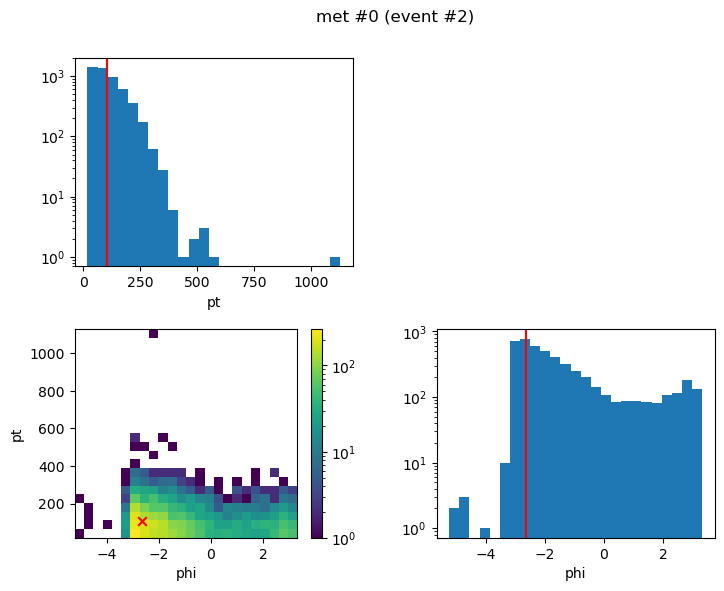

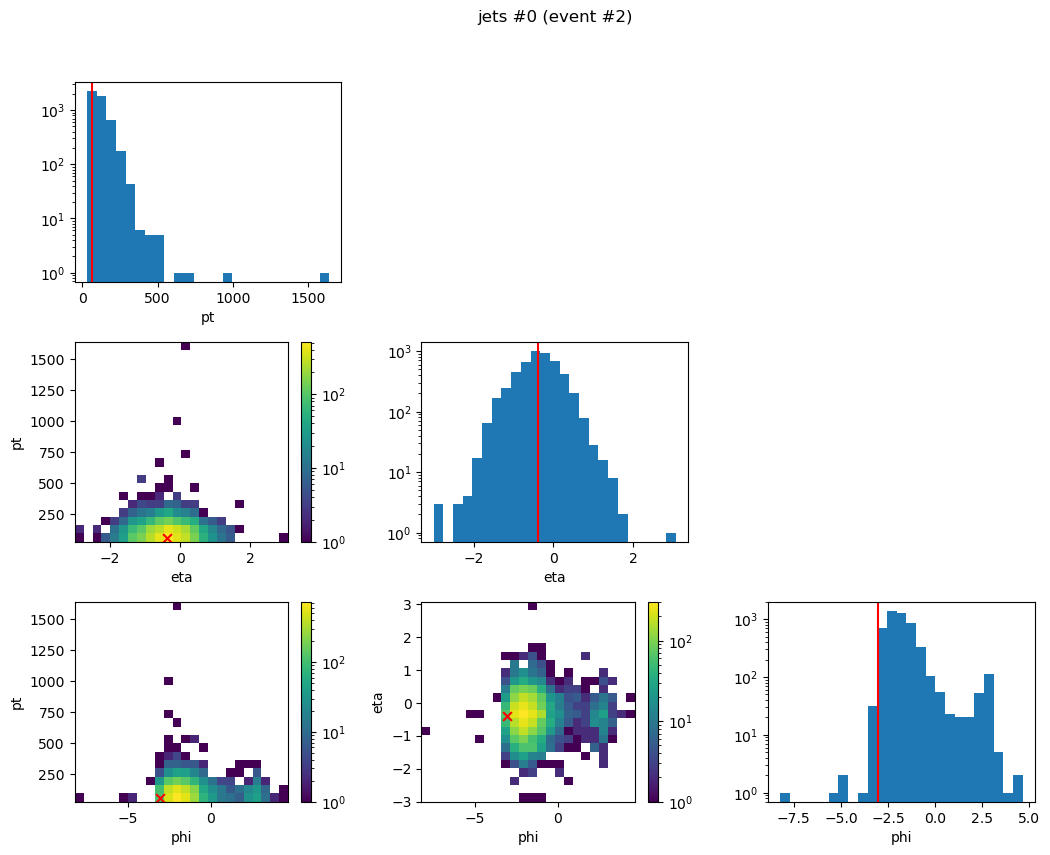

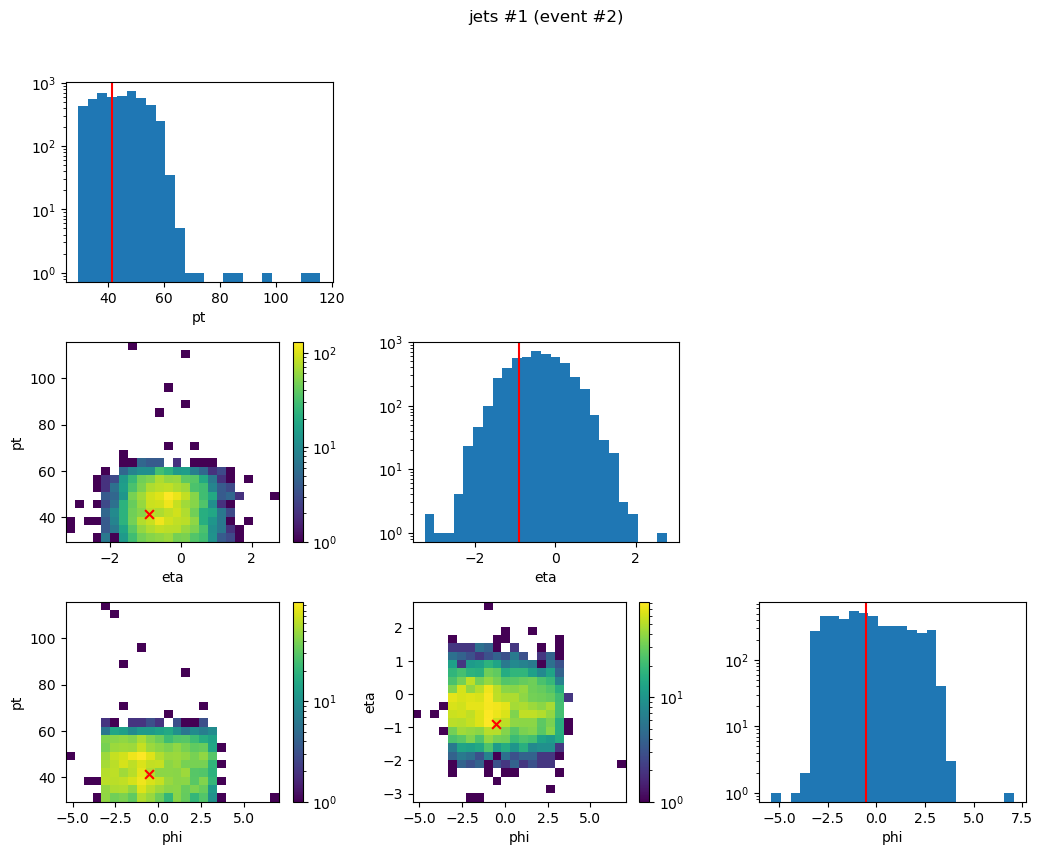

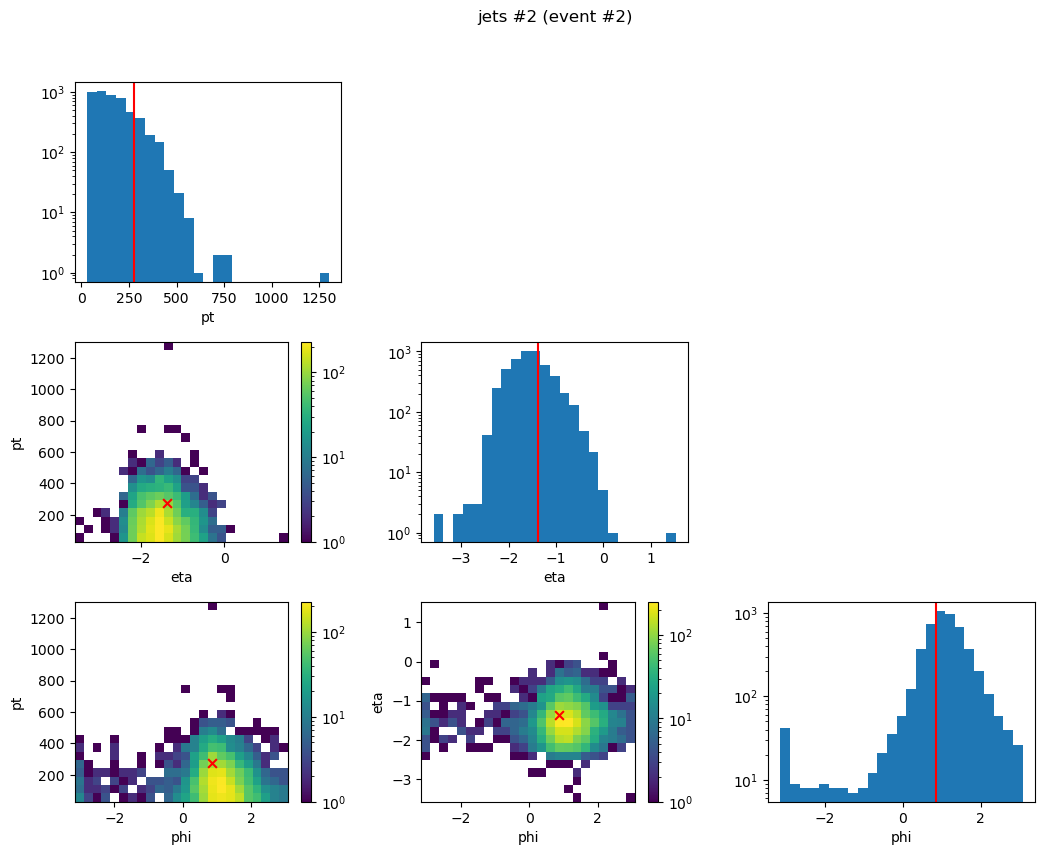

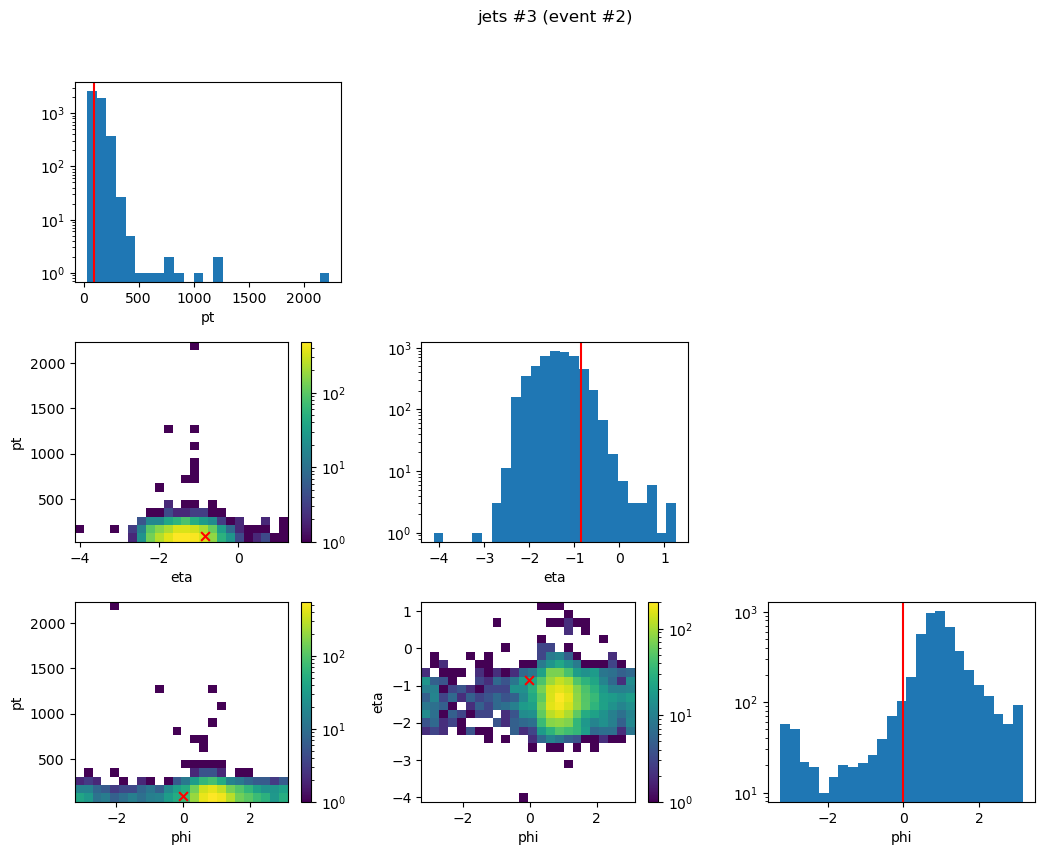

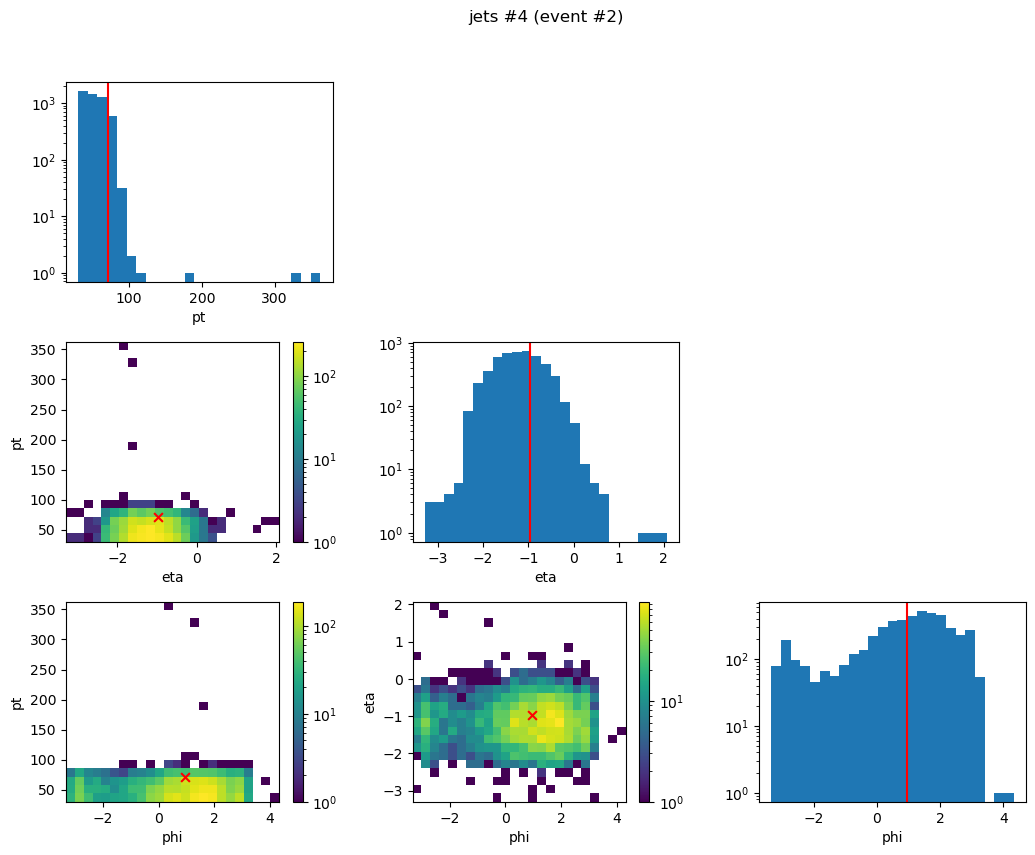

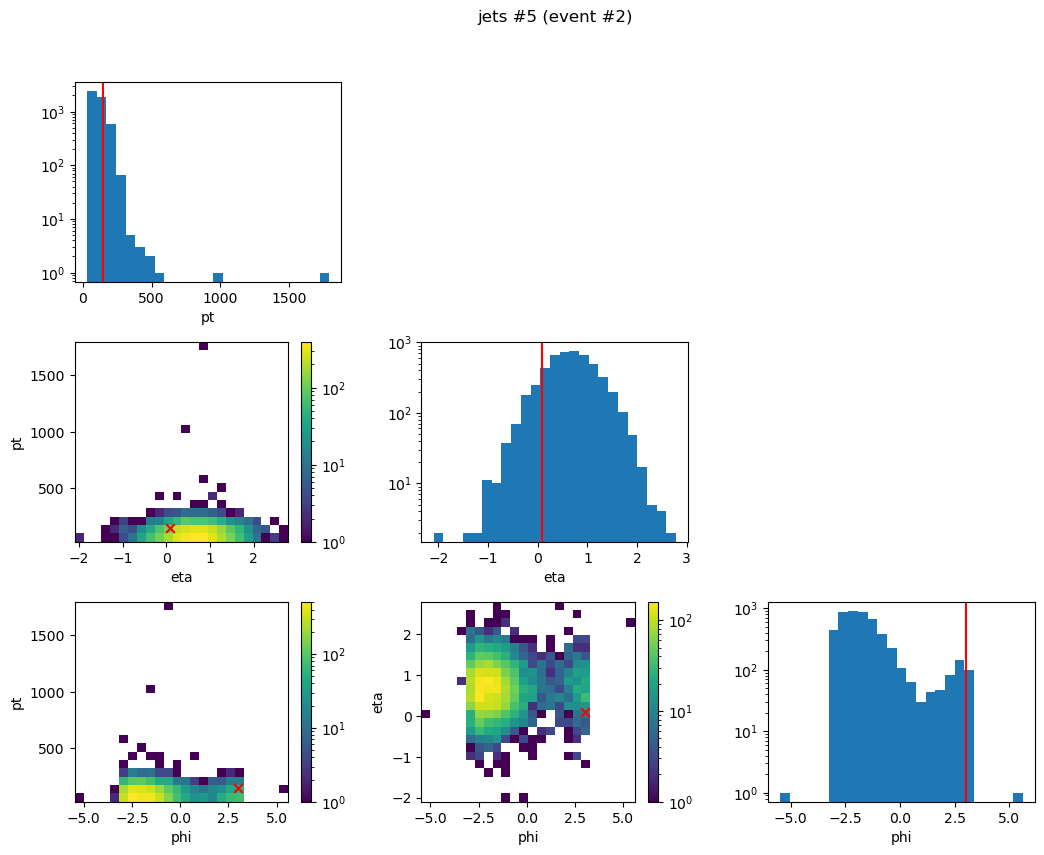

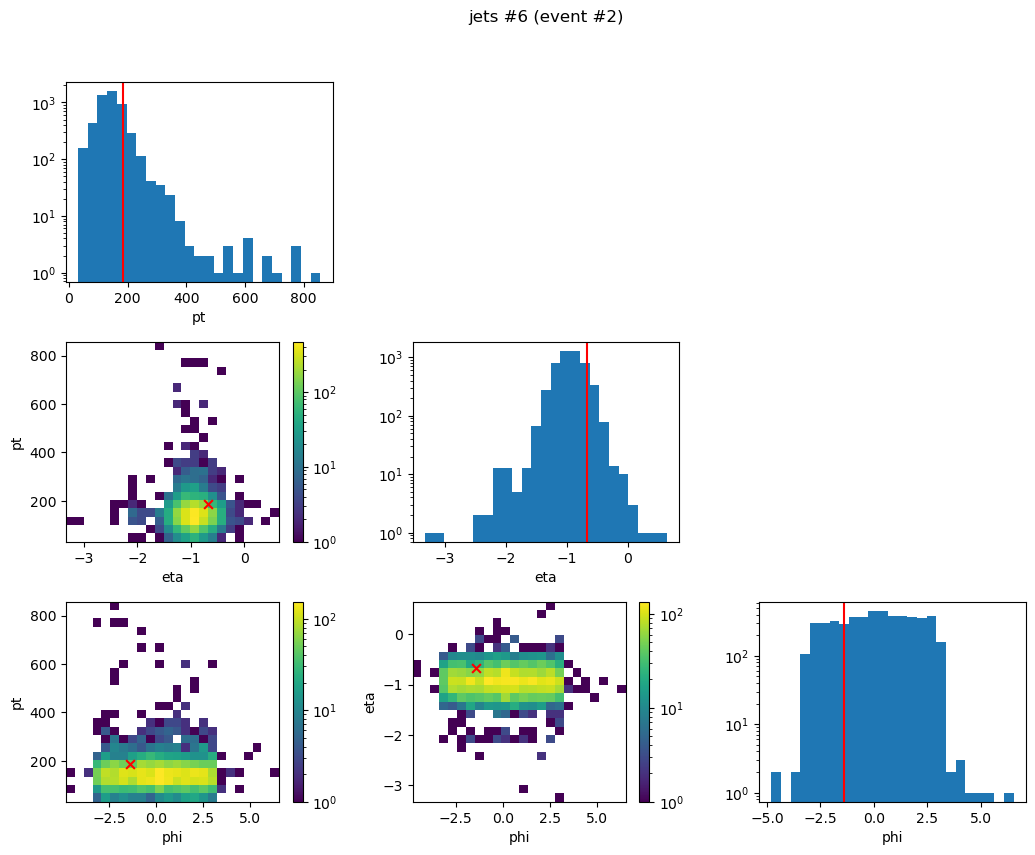

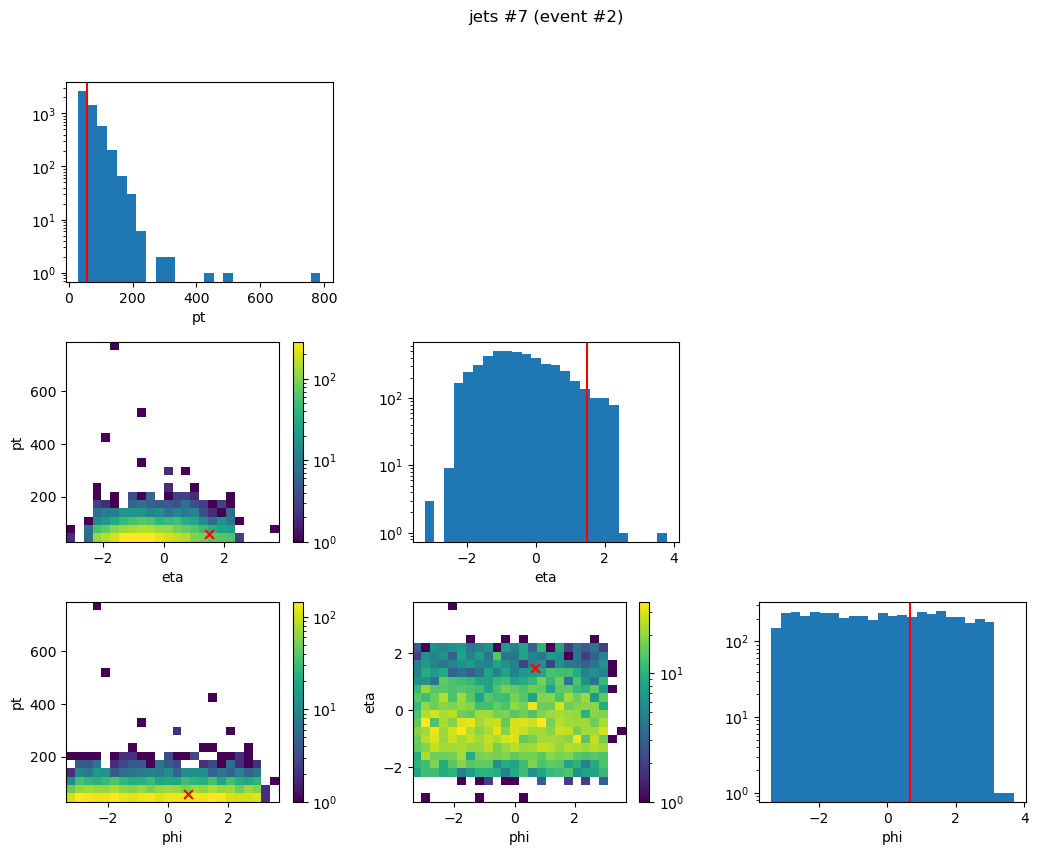

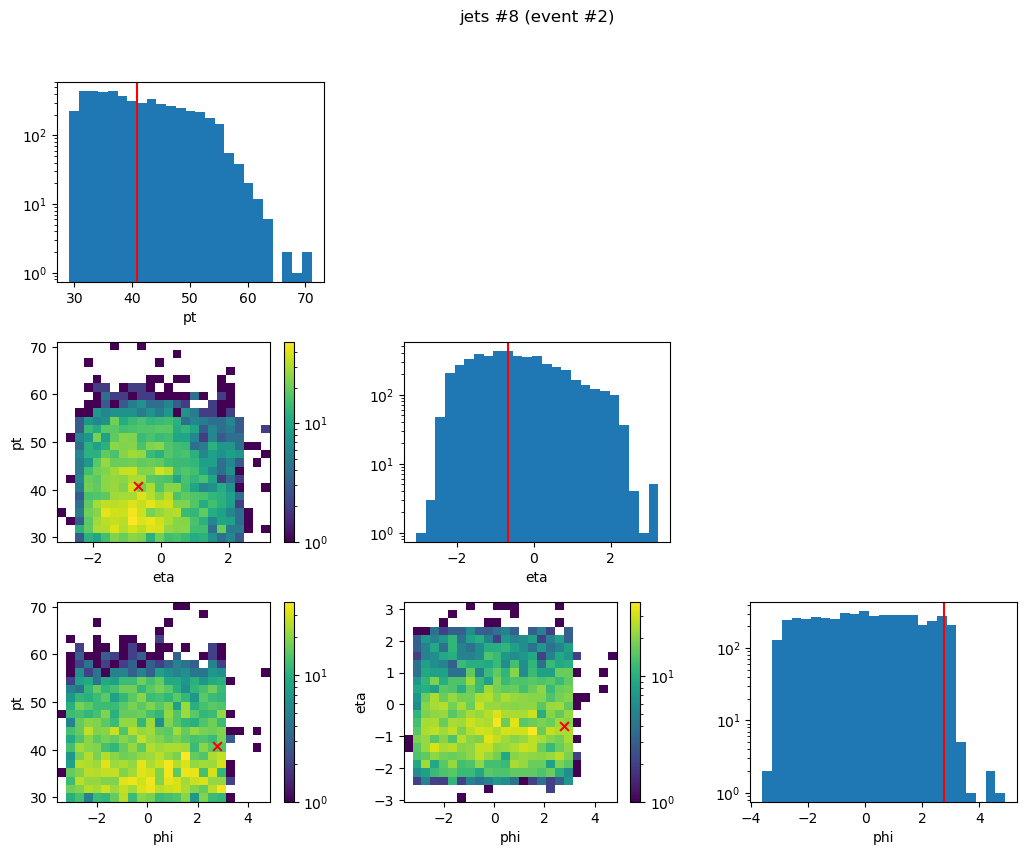

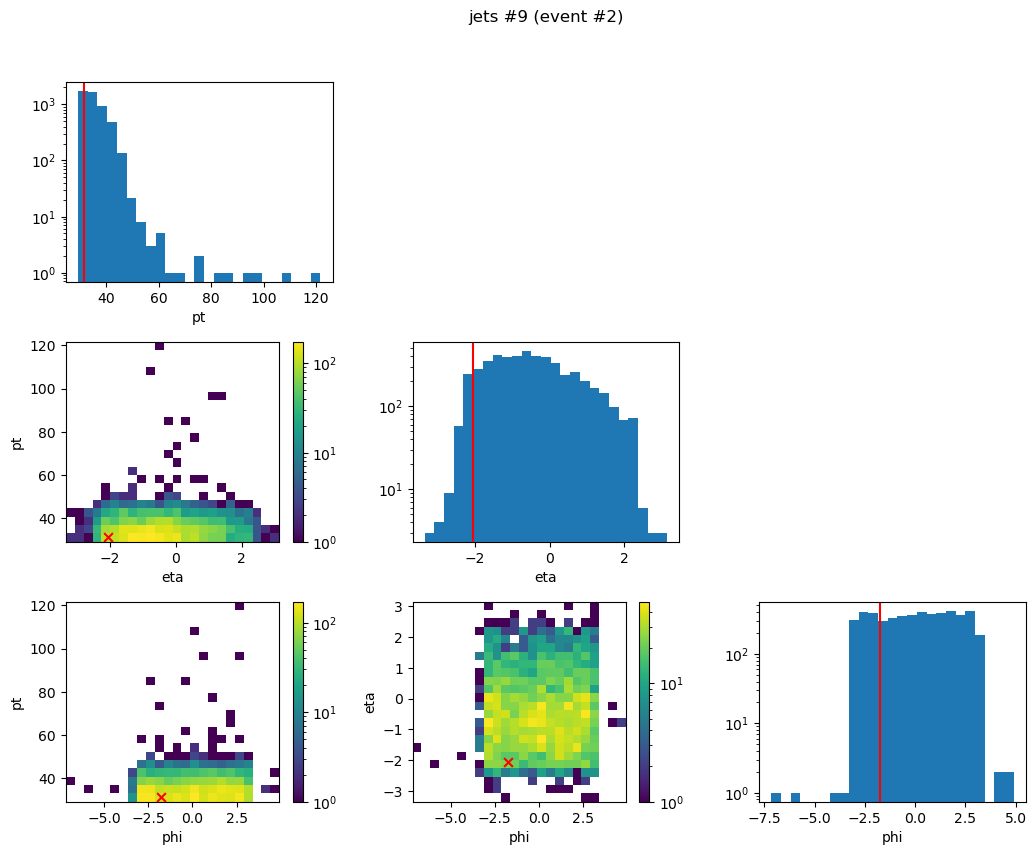

{('event_0_obj_lepton_0',): <Figure size 1200x900 with 12 Axes>,
 ('event_0_obj_met_0',): <Figure size 800x600 with 5 Axes>,
 ('event_0_obj_jets_0',): <Figure size 1200x900 with 12 Axes>,
 ('event_0_obj_jets_1',): <Figure size 1200x900 with 12 Axes>,
 ('event_0_obj_jets_2',): <Figure size 1200x900 with 12 Axes>,
 ('event_0_obj_jets_3',): <Figure size 1200x900 with 12 Axes>,
 ('event_0_obj_jets_4',): <Figure size 1200x900 with 12 Axes>,
 ('event_0_obj_jets_5',): <Figure size 1200x900 with 12 Axes>,
 ('event_0_obj_jets_6',): <Figure size 1200x900 with 12 Axes>,
 ('event_0_obj_jets_7',): <Figure size 1200x900 with 12 Axes>,
 ('event_0_obj_jets_8',): <Figure size 1200x900 with 12 Axes>,
 ('event_0_obj_jets_9',): <Figure size 1200x900 with 12 Axes>,
 ('event_1_obj_lepton_0',): <Figure size 1200x900 with 12 Axes>,
 ('event_1_obj_met_0',): <Figure size 800x600 with 5 Axes>,
 ('event_1_obj_jets_0',): <Figure size 1200x900 with 12 Axes>,
 ('event_1_obj_jets_1',): <Figure size 1200x900 with 12 A

In [18]:
# model = torch.load(model,'model.pt')
# sampling = callbacks[2]
sampling.make_sampling_plots(model,show=True)